In [1]:
# To reload modified python modules
%load_ext autoreload
%autoreload 2

The graph heat kernel represents the diffusion of heat in a graph across time, and it captures graph features at increasing scales as time advances. In many applications, people perform tests on graphs using the heat kernel at a single time, which raises the question of how to compare graphs that have features at multiple scales that the heat kernel cannot capture simultaneously. We study that question in the following notebook using nested cycles of cliques.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc_context

# Optimal transport
from ot.gromov import gromov_wasserstein
from utils.gw_ms import gromov_wasserstein_ms

# Graph functions
import networkx as nx
from utils.graph_functions import *

# Utilities
from time import time
from utils.utils import display_time, sampling_simplex_log
from utils.block_functions import *

# Path to save figures
from pathlib import Path

folder_figs = "figures"

# Examples of cycles of graphs

A cycle of graphs is a graph formed by joining several subgraphs into a cycle.

The cell below produces a 5-cycle of graphs formed by the cycles $C_3, \dots, C_7$.

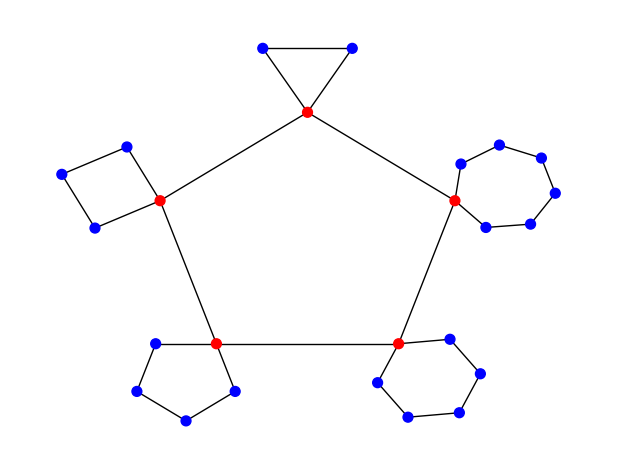

In [3]:
# Construct a cycle graph of graphs
sizes = [[3], [4], [5], [6], [7]]
n = len(sizes)
G = cycle_of_generators_variable(nx.cycle_graph, sizes)

# Compute positions of inner graphs
pos_list = [pos_cycle(s[0]) for s in sizes]
pos = pos_cycle_of_graphs(pos_list)

# Paint basepoints of inner graphs with a different color
bp = 0
ids = 0
color_map = []
for idx in range(G.number_of_nodes()):
    # Paint basepoint red
    if idx == bp:
        color_map.append("red")

        # Find next basepoint
        bp += sizes[ids][0]
        ids += 1
    # Paint other vertices in blue
    else:
        color_map.append("blue")

fig1 = plt.figure()
ax1 = plt.gca()
fig1.tight_layout(pad=0)
nx.draw(G, pos, node_size=50, ax=ax1, node_color=color_map)

Now we produce a 3-nested cycle of cliques $G$ of type (5,4,7). Specifically, $G$ is a 5-cycle of graphs, where each subgraph is a 4-cycle of cliques of size 7.

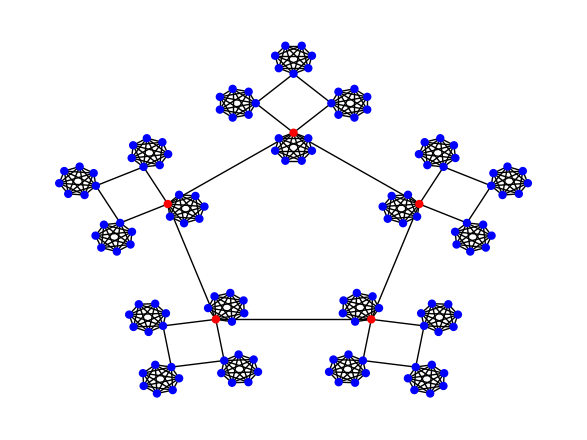

In [4]:
params = [5, 4, 7]
G = nested_cycles(*params)
pos = pos_nested_cycles(*params, scale=3)

# Paint basepoints of inner graphs with a different color
bp = 0
ds = np.prod(params[1:])
color_map = []
for idx in range(G.number_of_nodes()):
    # Paint basepoint red
    if idx == bp:
        color_map.append("red")

        # Find next basepoint
        bp += ds
    # Paint other vertices in blue
    else:
        color_map.append("blue")

fig2 = plt.figure()
ax2 = plt.gca()
fig2.tight_layout()
nx.draw(G, pos, node_size=25, ax=ax2, node_color=color_map)

Save figures for publication

In [5]:
fig_list = [(fig1, ax1), (fig2, ax2)]
names = ["Cycle_of_graphs.pdf", "Cycle_of_cliques.pdf"]

for idx, (fig, ax) in enumerate(fig_list):
    name = names[idx]

    # Remove whitespace around NetworkX plots
    # (it didn't work, but I'm leaving it here for reference)
    ax.set_axis_off()
    fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    ax.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    fig.savefig(Path(folder_figs, name), bbox_inches="tight", pad_inches=0)

# Heat kernels of 2-nested cycles
We say that a 2-nested cycle of cliques has features at 2 levels: the outer cycle is level 1, and the smaller cycles, level 2. We conjecture that the graph heat kernel does not capture features at both levels at any specific time, but a combination of 2 heat kernels does. We test that hypothesis with a pair of 2-nested cycles of cliques $G_1$ and $G_2$ of types (10, 5, 5) and (10, 5, 20).

The benchmark for this experiment is an optimal coupling for the GW distance between $G_1$ and $G_2$ treated as metric spaces with the shortest path distance. Note that the optimal coupling is a block matrix with features at 2 levels. The outer blocks of the matrix form a cyclic permutation of 10-cycles (this is level 1), and each block is itself a cyclic permutation of 5-cycles (this is level 2). Here is a picture:

![This coupling has the right nested structure: 10 large blocks forming a cyclic permutation, and each block has 5 sub-blocks arranged as a cyclic permutation.]\(figures/block_coupling.png\)

Returning to heat kernels, suppose we compute the GW distance between the heat kernels $H_{1,t}$ and $H_{2,t}$ of $G_1$ and $G_2$ for a fixed time $t>0$. When we say that a single heat kernel cannot capture features at both levels, we mean that an optimal coupling does not have the block structure described in the previous paragraph. Either the 10 outer blocks or at least one set of 5 sub-blocks do not form a cyclic permutation of the correct size.

In contrast, the parametrized GW distance between pairs of heat kernels does capture the multiscale structure.

## Generate graphs

In [6]:
params2 = [[10, 5, 5], [10, 5, 20]]
nGraphs2 = len(params2)

# Create figure if we want to see the graphs
plot = False
if plot:
    fig, axes = plt.subplots(1, nGraphs2, figsize=(20, 5))

Graphs2 = []
for idx, param in enumerate(params2):
    G = nested_cycles(*param)
    Graphs2.append(G)

    if plot:
        pos = pos_nested_cycles(*param, scale=5)
        nx.draw(G, ax=axes[idx], pos=pos)

## Generate heat kernels

In [7]:
normalize = False
compute_diagonal = False

t_0 = 10
step_size = 10
n_times = 50
Times_all = t_0 + np.arange(0, n_times * step_size, step_size)
print(Times_all)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400 410 420 430 440 450 460 470 480 490 500]


In [8]:
# For each graph, generate heat kernels for all times
Hs_all = []

for idg in range(nGraphs2):
    G = Graphs2[idg]

    H_G = []
    for idt in range(n_times):
        time_start = time()

        t = Times_all[idt]
        H = heat_kernel(G, t)

        if normalize:
            H /= np.linalg.norm(H)
        H_G.append(H)

        time_end = time()
        print(
            "(%i, %i)/(%i, %i): %s"
            % (
                idg + 1,
                idt + 1,
                nGraphs2,
                n_times,
                display_time(time_end - time_start),
            )
        )

    Hs_all.append(H_G)

(1, 1)/(2, 50): 0:00:00.14
(1, 2)/(2, 50): 0:00:00.00
(1, 3)/(2, 50): 0:00:00.01
(1, 4)/(2, 50): 0:00:00.01
(1, 5)/(2, 50): 0:00:00.02
(1, 6)/(2, 50): 0:00:00.01
(1, 7)/(2, 50): 0:00:00.01
(1, 8)/(2, 50): 0:00:00.00
(1, 9)/(2, 50): 0:00:00.01
(1, 10)/(2, 50): 0:00:00.01
(1, 11)/(2, 50): 0:00:00.01
(1, 12)/(2, 50): 0:00:00.01
(1, 13)/(2, 50): 0:00:00.01
(1, 14)/(2, 50): 0:00:00.01
(1, 15)/(2, 50): 0:00:00.01
(1, 16)/(2, 50): 0:00:00.01
(1, 17)/(2, 50): 0:00:00.01
(1, 18)/(2, 50): 0:00:00.01
(1, 19)/(2, 50): 0:00:00.01
(1, 20)/(2, 50): 0:00:00.01
(1, 21)/(2, 50): 0:00:00.01
(1, 22)/(2, 50): 0:00:00.01
(1, 23)/(2, 50): 0:00:00.01
(1, 24)/(2, 50): 0:00:00.01
(1, 25)/(2, 50): 0:00:00.01
(1, 26)/(2, 50): 0:00:00.01
(1, 27)/(2, 50): 0:00:00.01
(1, 28)/(2, 50): 0:00:00.01
(1, 29)/(2, 50): 0:00:00.01
(1, 30)/(2, 50): 0:00:00.04
(1, 31)/(2, 50): 0:00:00.01
(1, 32)/(2, 50): 0:00:00.02
(1, 33)/(2, 50): 0:00:00.01
(1, 34)/(2, 50): 0:00:00.01
(1, 35)/(2, 50): 0:00:00.01
(1, 36)/(2, 50): 0:00:00.01
(

### Heat kernel graphs

The extreme values of the heat kernels of $G_1$ and $G_2$ are several orders of magnitude apart, even if we normalize by the Frobenius norm. Because of this, the computation of the parametrized GW distance gets dominated by the heat kernels at a single time if the parameter `nu` is the uniform measure. This means that the optimal couplings for the parametrized GW distance between pairs of kernels and the regular GW distance between individual kernels would be very similar. We later tune `nu` to avoid this issue.

In [9]:
# 0: min
# 1: max
# 2: average
H_ranges_all = np.zeros((nGraphs2, n_times, 3))
H_ranges_normalized = np.zeros((nGraphs2, n_times, 3))


for idg in range(nGraphs2):
    for idt in range(n_times):
        # unnormalized
        H = Hs_all[idg][idt]
        H_ranges_all[idg, idt, 0] = np.min(H)
        H_ranges_all[idg, idt, 1] = np.max(H)
        H_ranges_all[idg, idt, 2] = np.mean(H)

        # normalized
        H = H / np.linalg.norm(H)
        H_ranges_normalized[idg, idt, 0] = np.min(H)
        H_ranges_normalized[idg, idt, 1] = np.max(H)
        H_ranges_normalized[idg, idt, 2] = np.mean(H)

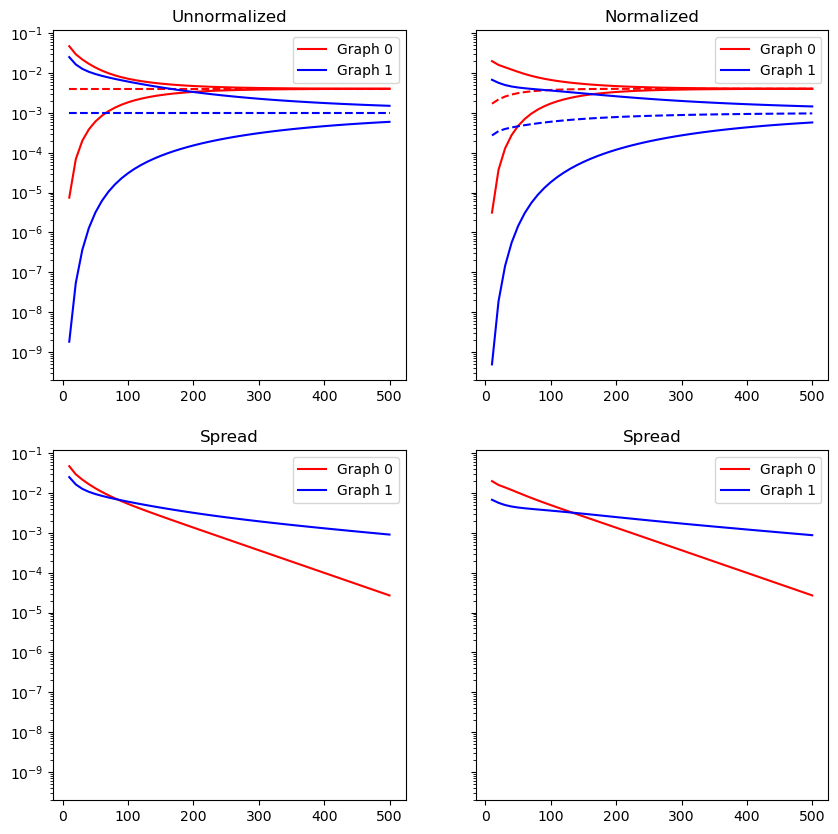

In [10]:
colors = ["red", "blue"]

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 10))

# Heat kernels
for idg in range(nGraphs2):
    axes[0, 0].plot(Times_all, H_ranges_all[idg, :, 0], colors[idg])
    axes[0, 0].plot(
        Times_all, H_ranges_all[idg, :, 1], colors[idg], label=f"Graph {idg}"
    )
    axes[0, 0].plot(Times_all, H_ranges_all[idg, :, 2], colors[idg], linestyle="--")
axes[0, 0].set_title("Unnormalized")
axes[0, 0].legend()
axes[0, 0].set_yscale("log")

# Normalized heat kernel
for idg in range(nGraphs2):
    axes[0, 1].plot(Times_all, H_ranges_normalized[idg, :, 0], colors[idg])
    axes[0, 1].plot(
        Times_all, H_ranges_normalized[idg, :, 1], colors[idg], label=f"Graph {idg}"
    )
    axes[0, 1].plot(
        Times_all, H_ranges_normalized[idg, :, 2], colors[idg], linestyle="--"
    )
axes[0, 1].set_title("Normalized")
axes[0, 1].legend()
axes[0, 1].set_yscale("log")


for idg in range(nGraphs2):
    axes[1, 0].plot(
        Times_all,
        H_ranges_all[idg, :, 1] - H_ranges_all[idg, :, 0],
        color=colors[idg],
        label=f"Graph {idg}",
    )
    axes[1, 0].set_title("Spread")
    axes[1, 0].legend()

    axes[1, 1].plot(
        Times_all,
        H_ranges_normalized[idg, :, 1] - H_ranges_normalized[idg, :, 0],
        color=colors[idg],
        label=f"Graph {idg}",
    )
    axes[1, 1].set_title("Spread")
    axes[1, 1].legend()

axes[1, 0].set_yscale("log")
axes[1, 1].set_yscale("log")

## GW distance between heat kernels

Now we compute the GW distance between the heat kernels $H_{1,t}$ and $H_{2,t}$ for all $t$ in `Times_all`.

In [11]:
# Compute dGW between each step
dGW_all = np.zeros(n_times)
Ts_all = np.zeros(n_times, dtype=object)
Trees_all = []

for idt in range(n_times):
    print("Step: %i/%i" % (idt + 1, n_times))

    H1 = Hs_all[0][idt]
    H2 = Hs_all[1][idt]

    time_start = time()
    T, log = gromov_wasserstein(
        H1,
        H2,
        log=True,
        verbose=0,
        # max_iter=1e3,
        tol_abs=1e-15,
        tol_rel=1e-15,
    )
    time_end = time()
    print("Time: " + display_time(time_end - time_start))
    print()

    dGW_all[idt] = 0.5 * np.sqrt(log["gw_dist"])
    Ts_all[idt] = T

    # Block tree
    Trees_all.append(extract_multiscale_info(T, params2[0], params2[1]))

Step: 1/50
Time: 0:00:00.18

Step: 2/50
Time: 0:00:00.30

Step: 3/50
Time: 0:00:00.25

Step: 4/50
Time: 0:00:00.20

Step: 5/50
Time: 0:00:00.30

Step: 6/50
Time: 0:00:00.25

Step: 7/50
Time: 0:00:00.22

Step: 8/50
Time: 0:00:00.21

Step: 9/50
Time: 0:00:00.18

Step: 10/50
Time: 0:00:00.16

Step: 11/50
Time: 0:00:00.27

Step: 12/50
Time: 0:00:00.29

Step: 13/50
Time: 0:00:00.19

Step: 14/50
Time: 0:00:00.31

Step: 15/50
Time: 0:00:00.47

Step: 16/50
Time: 0:00:00.53

Step: 17/50
Time: 0:00:00.48

Step: 18/50
Time: 0:00:00.46

Step: 19/50
Time: 0:00:00.35

Step: 20/50
Time: 0:00:00.34

Step: 21/50
Time: 0:00:00.32

Step: 22/50
Time: 0:00:00.48

Step: 23/50
Time: 0:00:00.30

Step: 24/50
Time: 0:00:00.21

Step: 25/50
Time: 0:00:00.36

Step: 26/50
Time: 0:00:00.28

Step: 27/50
Time: 0:00:00.39

Step: 28/50
Time: 0:00:00.30

Step: 29/50
Time: 0:00:00.33

Step: 30/50
Time: 0:00:00.26

Step: 31/50
Time: 0:00:00.26

Step: 32/50
Time: 0:00:00.30

Step: 33/50
Time: 0:00:00.29

Step: 34/50
Time: 0

The vector `cyclic` in the graph below indicates if the GW coupling has the right block structure at levels 1 and 2. Remember that at level 1, we want to see 10 blocks arranged in a cyclic permutation and at level 2, each of the 10 blocks should have 5 sub-blocks arranged in a cyclic permutation.

When $t \leq 50$, the GW couplings detect small scale features as indicated by `cyclic=[0,1]`. However, there is a phase change after that, and `cyclic` equals `[1,0]` or `[0,0]` for $t \geq 60$. We never get `cyclic = [1,1]`.

  0/50 Cyclic: [0 0] (num=0)
  1/50 Cyclic: [0 1] (num=1)
  2/50 Cyclic: [0 1] (num=1)
  3/50 Cyclic: [0 1] (num=1)
  4/50 Cyclic: [0 1] (num=1)
  5/50 Cyclic: [0 0] (num=0)
  6/50 Cyclic: [0 0] (num=0)
  7/50 Cyclic: [0 0] (num=0)
  8/50 Cyclic: [0 0] (num=0)
  9/50 Cyclic: [0 0] (num=0)
 10/50 Cyclic: [0 0] (num=0)
 11/50 Cyclic: [0 0] (num=0)
 12/50 Cyclic: [0 0] (num=0)
 13/50 Cyclic: [1 0] (num=1)
 14/50 Cyclic: [1 0] (num=1)
 15/50 Cyclic: [1 0] (num=1)
 16/50 Cyclic: [1 0] (num=1)
 17/50 Cyclic: [1 0] (num=1)
 18/50 Cyclic: [1 0] (num=1)
 19/50 Cyclic: [1 0] (num=1)
 20/50 Cyclic: [1 0] (num=1)
 21/50 Cyclic: [1 0] (num=1)
 22/50 Cyclic: [1 0] (num=1)
 23/50 Cyclic: [1 0] (num=1)
 24/50 Cyclic: [1 0] (num=1)
 25/50 Cyclic: [1 0] (num=1)
 26/50 Cyclic: [1 0] (num=1)
 27/50 Cyclic: [1 0] (num=1)
 28/50 Cyclic: [1 0] (num=1)
 29/50 Cyclic: [1 0] (num=1)
 30/50 Cyclic: [1 0] (num=1)
 31/50 Cyclic: [1 0] (num=1)
 32/50 Cyclic: [1 0] (num=1)
 33/50 Cyclic: [0 0] (num=0)
 34/50 Cyclic:

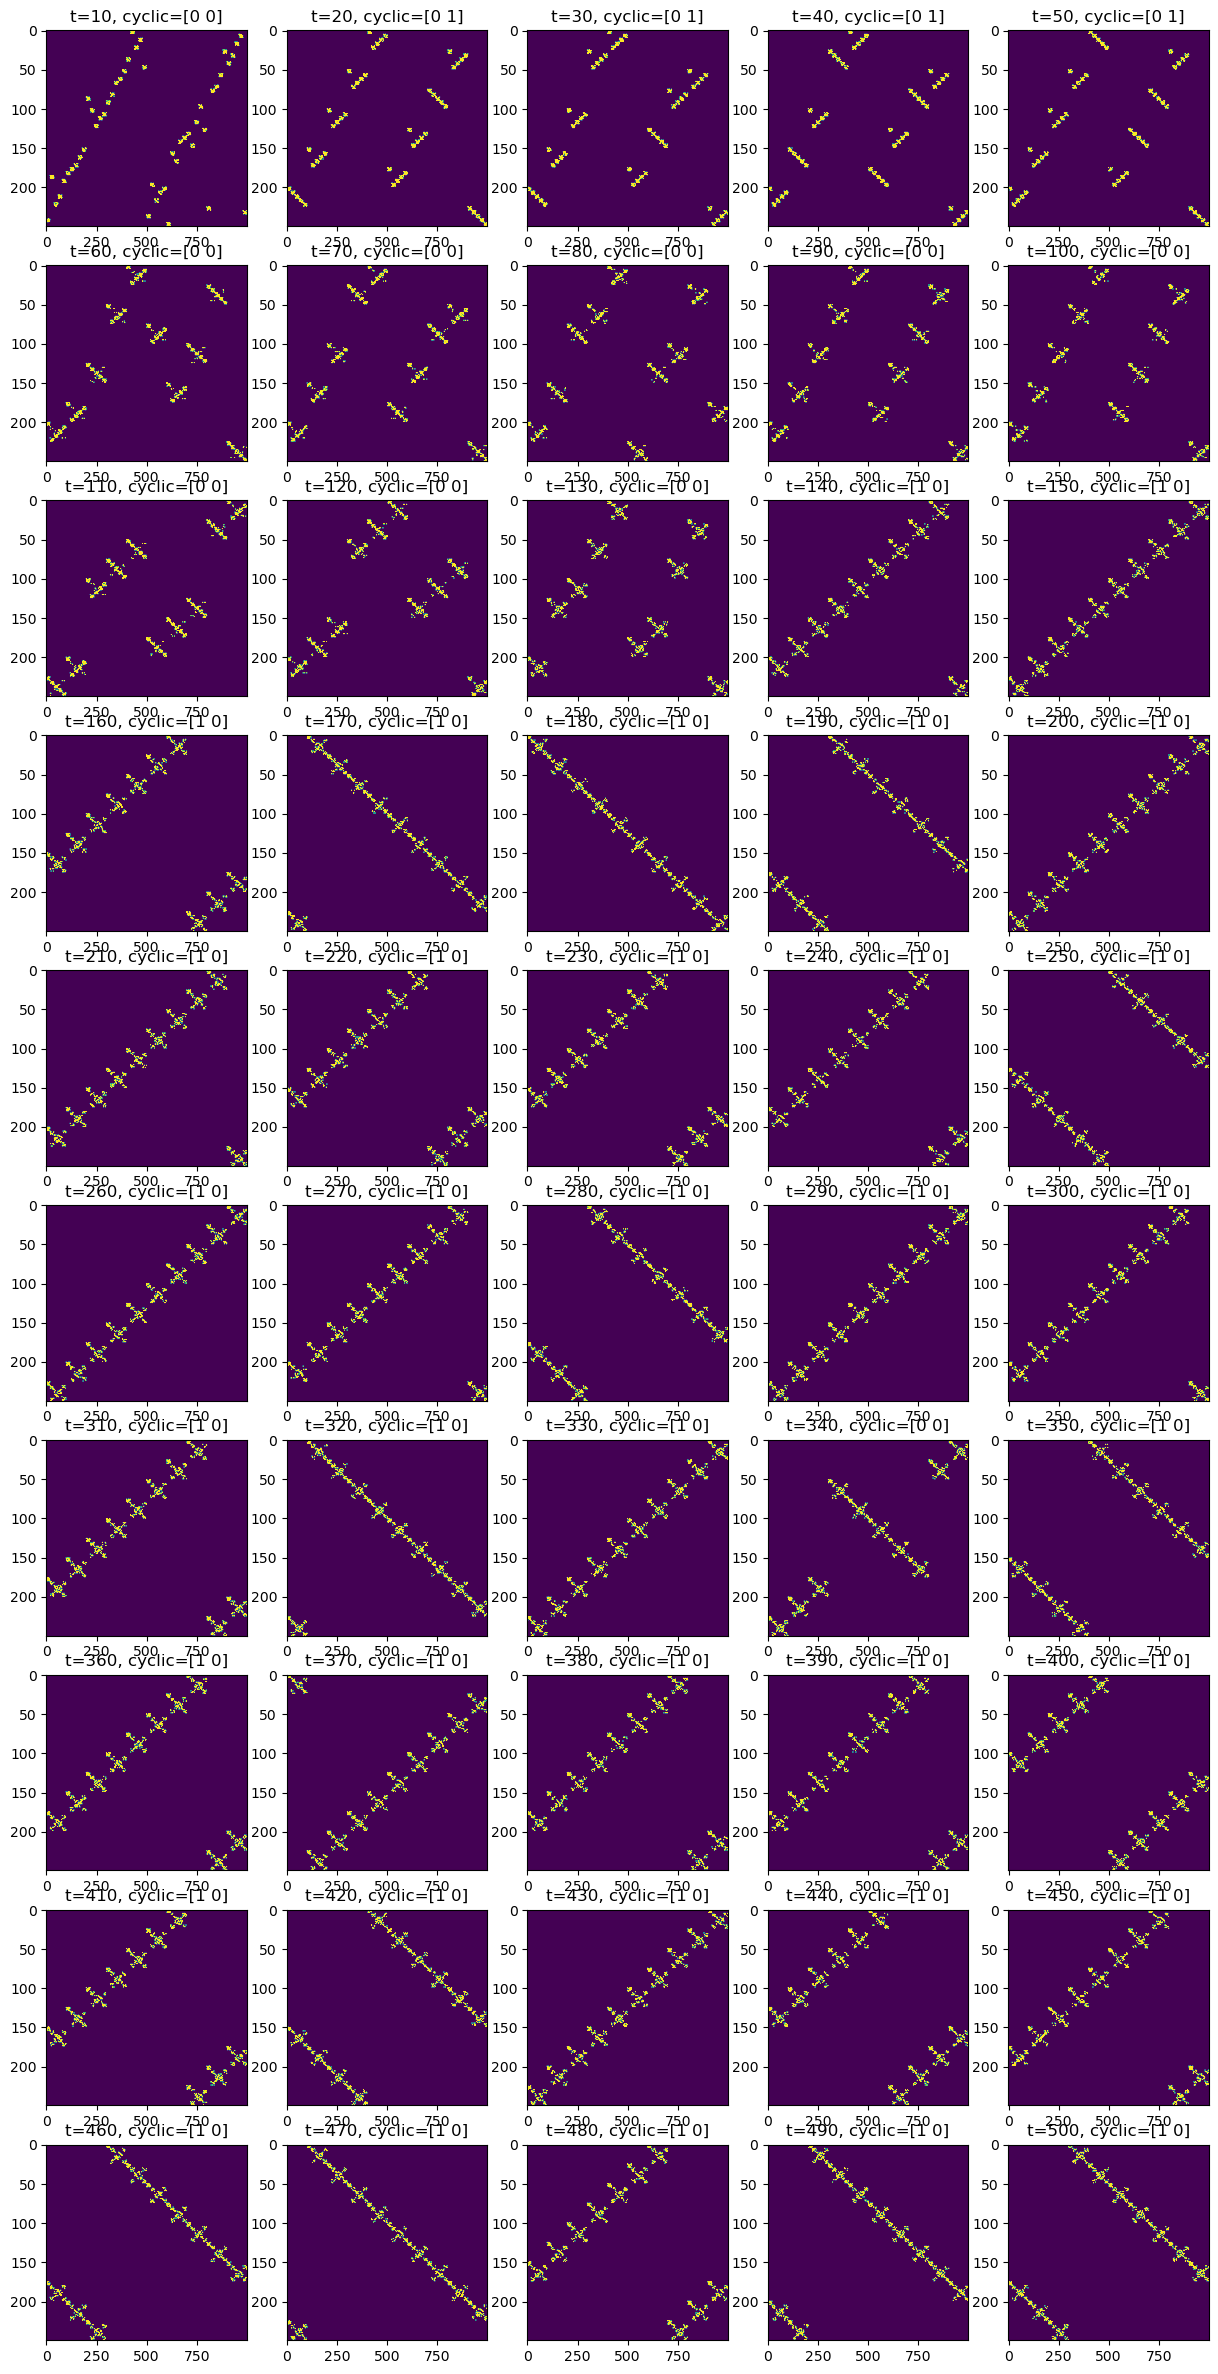

In [12]:
cols = np.min([n_times, 5])
ps = [int(np.ceil(n_times / cols)), cols]
scale = 3
fig, axes = plt.subplots(ps[0], ps[1], figsize=(scale * ps[1], scale * ps[0]))

# Plot all couplings with the same colorbar
for idt in range(n_times):
    T = Ts_all[idt]
    cyclic = cyclic_by_levels(Trees_all[idt])

    if ps[0] > 1:
        [r, c] = np.unravel_index(idt, ps)
        sp_idx = [r, c]
    else:
        sp_idx = [idt]
    im = axes[*sp_idx].imshow(
        T,
        vmin=0,
        vmax=0.0001,
        # Plots matrices as squares
        aspect="auto",
        # Pixels are enlarged to improve visibility
        interpolation="auto",
        interpolation_stage="data",
    )
    axes[*sp_idx].set_title("t=%i, cyclic=%s" % (Times_all[idt], str(cyclic)))

    print(
        "{:3d}/{} Cyclic: {} (num={})".format(idt, n_times, str(cyclic), np.sum(cyclic))
    )
    if all(cyclic):
        print(f" -- All cyclic! --")

### Format graphs for paper

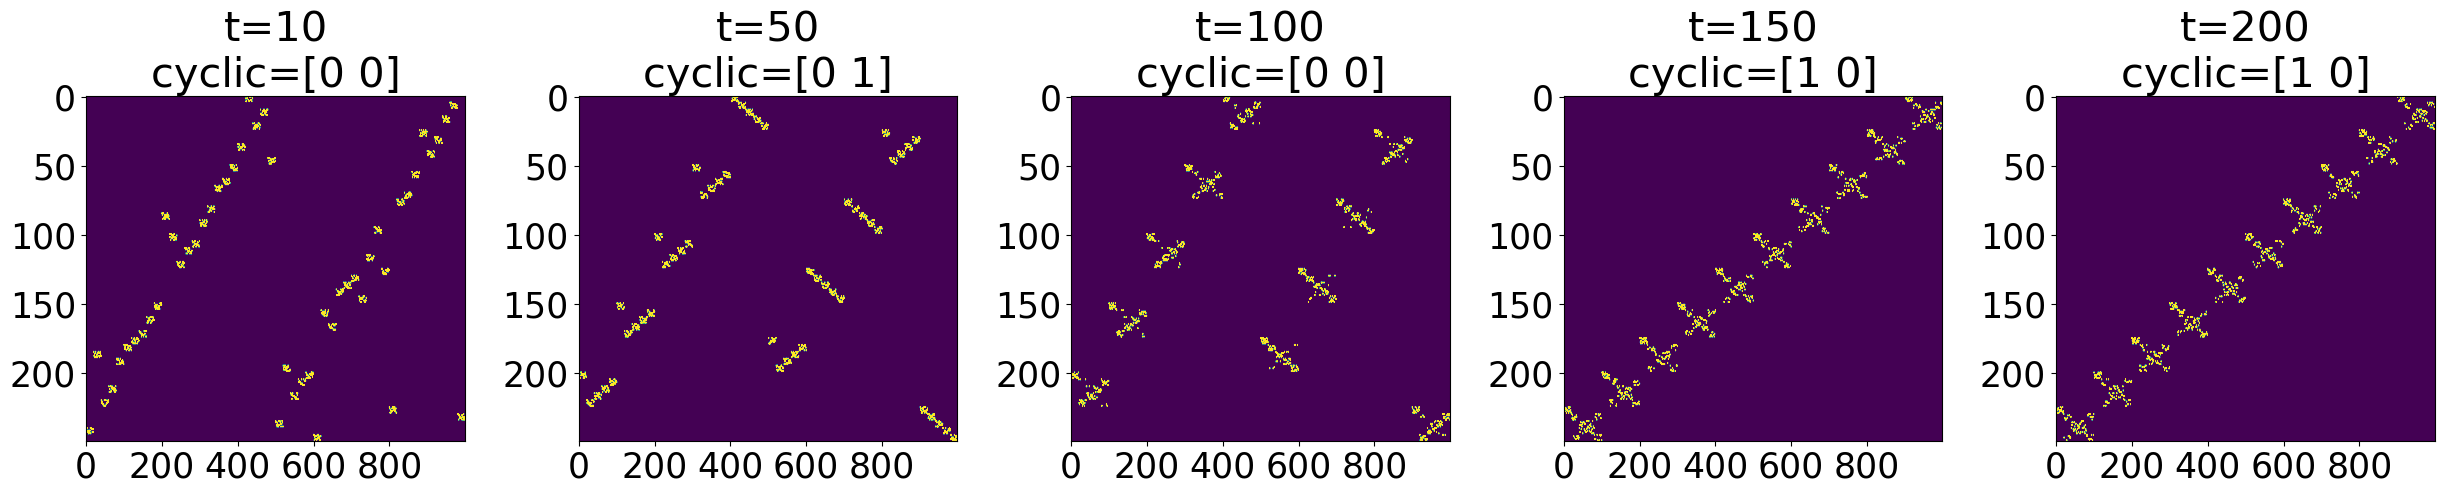

In [13]:
Times_plot = [10, 50, 100, 150, 200]
num_plots = len(Times_plot)

with rc_context({"font.size": 25}):
    scale = 5
    fig, axes = plt.subplots(
        1, num_plots, figsize=(scale * num_plots, scale + 0.5), sharey=False
    )
    for idx in range(num_plots):
        # Find index in global times list
        idt = np.where(Times_all == Times_plot[idx])[0][0]

        # Load coupling and find at which levels it's cyclic
        T = Ts_all[idt]
        cyclic = cyclic_by_levels(Trees_all[idt])

        # Plot
        im = axes[idx].imshow(
            T,
            vmin=0,
            vmax=0.0001,
            # Plots matrices as squares
            aspect="auto",
            # Pixels are enlarged to improve visibility
            interpolation="auto",
            interpolation_stage="data",
        )
        axes[idx].set_title("t=%i\ncyclic=%s" % (Times_all[idt], str(cyclic)))

    # Save for publication
    plt.tight_layout()
    plt.savefig(Path(folder_figs, "Nested_2_cycles_GW_small.pdf"), bbox_inches="tight")

## Multiscale distance, 2 levels
Now we try with the parametrized GW distance. We manually select two times `t_1` and `t_2` such that `cyclic = [0,1]` at `t_1` and `cyclic = [1,0]` at `t_2`. Hopefully, the parametrized GW distance can combine these two behaviors into one coupling with `cyclic=[1,1]`.

Also, because of the difference in extreme values of the heat kernels, we compute the parametrized GW distance for logarithmically spaced vectors `nu`.

In [14]:
# Select times
Times_nu = [50, 200]
I_nu = np.where(np.isin(Times_all, Times_nu))[0]

# Search over nu
nu_log_0 = -10
nNus = 20
nus = np.logspace(nu_log_0, 0, nNus + 1)

# Reshape
nus = nus[:-1, np.newaxis]

# Make each row sum 1
nus = np.concatenate((nus, 1 - nus), axis=1)

print(nus)
print("nNus:", nNus)

[[1.00000000e-10 1.00000000e+00]
 [3.16227766e-10 1.00000000e+00]
 [1.00000000e-09 9.99999999e-01]
 [3.16227766e-09 9.99999997e-01]
 [1.00000000e-08 9.99999990e-01]
 [3.16227766e-08 9.99999968e-01]
 [1.00000000e-07 9.99999900e-01]
 [3.16227766e-07 9.99999684e-01]
 [1.00000000e-06 9.99999000e-01]
 [3.16227766e-06 9.99996838e-01]
 [1.00000000e-05 9.99990000e-01]
 [3.16227766e-05 9.99968377e-01]
 [1.00000000e-04 9.99900000e-01]
 [3.16227766e-04 9.99683772e-01]
 [1.00000000e-03 9.99000000e-01]
 [3.16227766e-03 9.96837722e-01]
 [1.00000000e-02 9.90000000e-01]
 [3.16227766e-02 9.68377223e-01]
 [1.00000000e-01 9.00000000e-01]
 [3.16227766e-01 6.83772234e-01]]
nNus: 20


In [15]:
# dMS -- vary nu
dMS_nu = np.zeros(nNus)
Ts_nu = np.zeros(nNus, dtype=object)
Trees_nu = []  # Compute block trees

for idv in range(nNus):
    print("nu %i/%i" % (idv + 1, nNus))
    with np.printoptions(precision=3):
        print(nus[idv, :])

    # Load cost matrices and nu
    nu = nus[idv, :]
    H1 = [Hs_all[0][idt] for idt in I_nu]
    H2 = [Hs_all[1][idt] for idt in I_nu]

    # dMS
    time_start = time()
    T, log = gromov_wasserstein_ms(
        H1, H2, nu=nu, log=True, verbose=0, tol_abs=1e-30, tol_rel=1e-30
    )
    time_end = time()
    print("dMS_nu:" + display_time(time_end - time_start))

    dMS_nu[idv] = 0.5 * np.sqrt(log["gw_dist"])
    Ts_nu[idv] = T

    # Compute block tree
    Trees_nu.append(extract_multiscale_info(T, params2[0], params2[1]))

    print()

nu 1/20
[1.e-10 1.e+00]
dMS_nu:0:00:00.66

nu 2/20
[3.162e-10 1.000e+00]
dMS_nu:0:00:00.57

nu 3/20
[1.e-09 1.e+00]
dMS_nu:0:00:00.68

nu 4/20
[3.162e-09 1.000e+00]
dMS_nu:0:00:00.62

nu 5/20
[1.e-08 1.e+00]
dMS_nu:0:00:00.74

nu 6/20
[3.162e-08 1.000e+00]
dMS_nu:0:00:01.09

nu 7/20
[1.e-07 1.e+00]
dMS_nu:0:00:00.61

nu 8/20
[3.162e-07 1.000e+00]
dMS_nu:0:00:00.66

nu 9/20
[1.e-06 1.e+00]
dMS_nu:0:00:00.40

nu 10/20
[3.162e-06 1.000e+00]
dMS_nu:0:00:00.50

nu 11/20
[1.e-05 1.e+00]
dMS_nu:0:00:00.64

nu 12/20
[3.162e-05 1.000e+00]
dMS_nu:0:00:00.73

nu 13/20
[1.000e-04 9.999e-01]
dMS_nu:0:00:00.89

nu 14/20
[3.162e-04 9.997e-01]
dMS_nu:0:00:00.67

nu 15/20
[0.001 0.999]
dMS_nu:0:00:00.75

nu 16/20
[0.003 0.997]
dMS_nu:0:00:00.76

nu 17/20
[0.01 0.99]
dMS_nu:0:00:00.95

nu 18/20
[0.032 0.968]
dMS_nu:0:00:00.50

nu 19/20
[0.1 0.9]
dMS_nu:0:00:00.51

nu 20/20
[0.316 0.684]
dMS_nu:0:00:00.57



Now we get `cyclic=[1,1]` when `nu[0] = 1e-3` and `nu[0] 3.16e-3` (and `nu[1] = 1-nu[0]`)! The parametrized GW distance does combine the information from two instances of the heat kernel!

  0/20 Cyclic: [1 0] (num=1)
  1/20 Cyclic: [1 0] (num=1)
  2/20 Cyclic: [1 0] (num=1)
  3/20 Cyclic: [1 0] (num=1)
  4/20 Cyclic: [1 0] (num=1)
  5/20 Cyclic: [1 0] (num=1)
  6/20 Cyclic: [0 0] (num=0)
  7/20 Cyclic: [1 0] (num=1)
  8/20 Cyclic: [1 0] (num=1)
  9/20 Cyclic: [1 0] (num=1)
 10/20 Cyclic: [1 0] (num=1)
 11/20 Cyclic: [1 0] (num=1)
 12/20 Cyclic: [1 0] (num=1)
 13/20 Cyclic: [1 0] (num=1)
 14/20 Cyclic: [1 1] (num=2)
 -- All cyclic! --
 15/20 Cyclic: [1 1] (num=2)
 -- All cyclic! --
 16/20 Cyclic: [1 1] (num=2)
 -- All cyclic! --
 17/20 Cyclic: [0 1] (num=1)
 18/20 Cyclic: [0 1] (num=1)
 19/20 Cyclic: [0 1] (num=1)


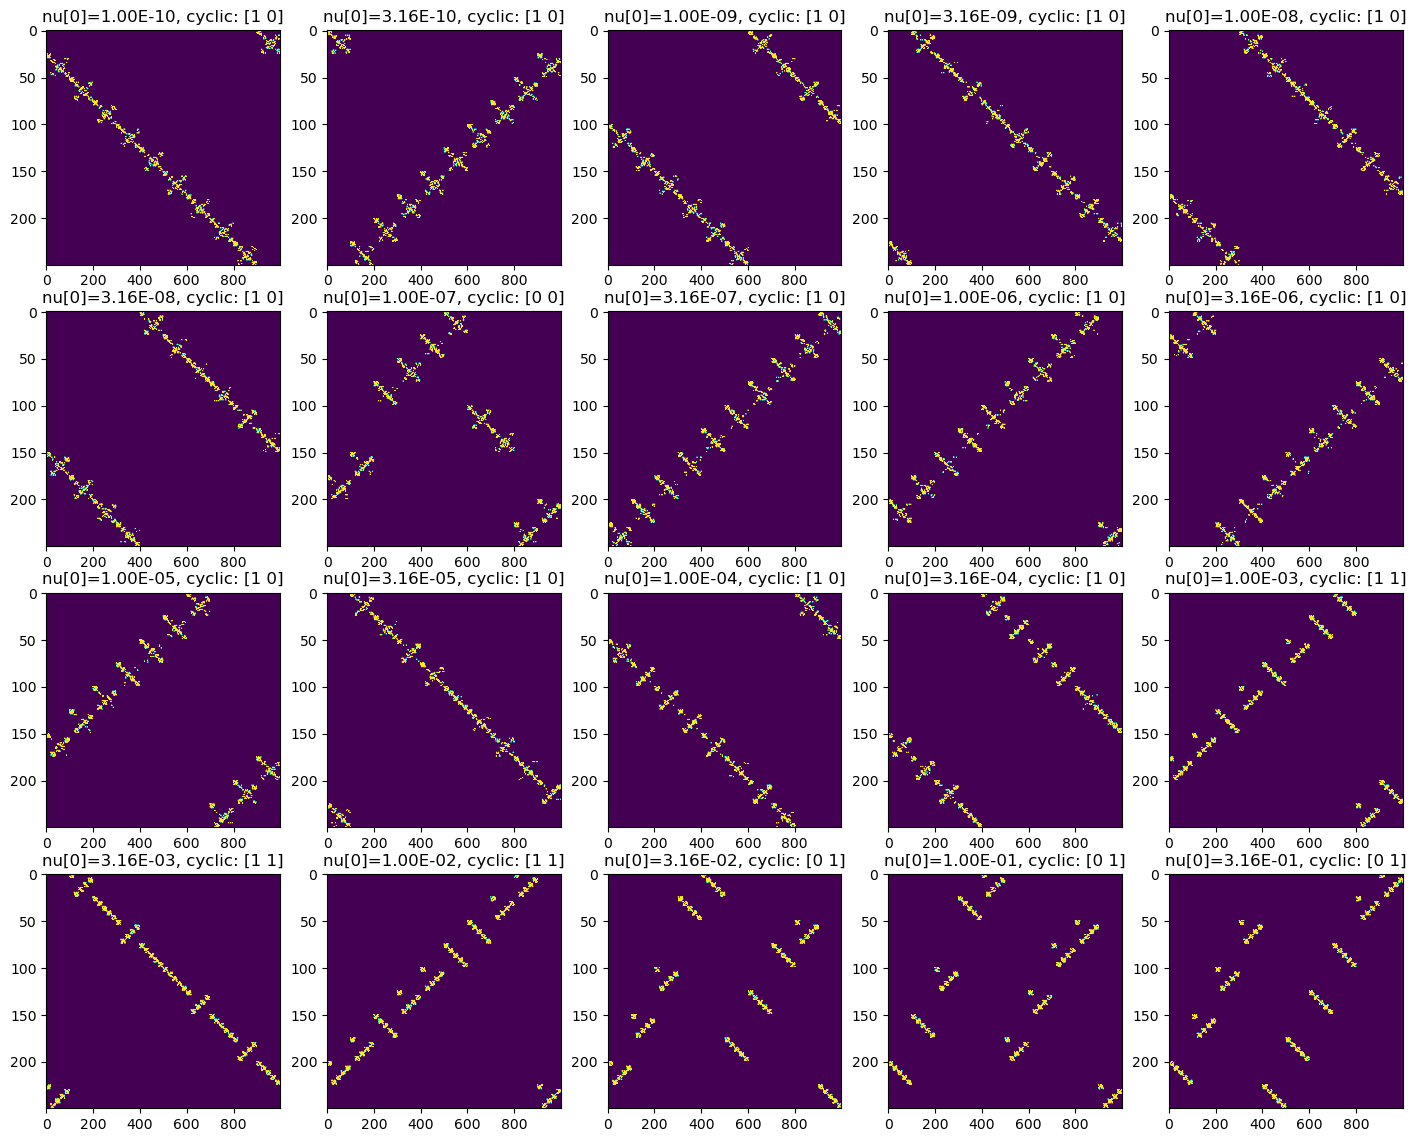

In [16]:
cols = np.min([nNus, 5])
ps = [int(np.ceil(nNus / cols)), cols]
fig, axes = plt.subplots(ps[0], ps[1], figsize=(3.5 * ps[1], 3.5 * ps[0]))

# Plot all couplings with the same colorbar
for idv in range(nNus):
    T = Ts_nu[idv]
    cyclic = cyclic_by_levels(Trees_nu[idv])

    if ps[0] > 1:
        [r, c] = np.unravel_index(idv, ps)
        sp_idx = [r, c]
    else:
        sp_idx = [idt]

    im = axes[*sp_idx].imshow(
        T,
        vmin=0,
        vmax=0.0001,
        # Plots matrices as squares
        aspect="auto",
        # Pixels are enlarged to improve visibility
        interpolation="auto",
        interpolation_stage="data",
    )

    axes[*sp_idx].set_title("nu[0]=%0.2E, cyclic: %s" % (nus[idv, 0], str(cyclic)))

    print("{:3d}/{} Cyclic: {} (num={})".format(idv, nNus, str(cyclic), np.sum(cyclic)))
    if all(cyclic):
        print(f" -- All cyclic! --")

### Format graphs for paper

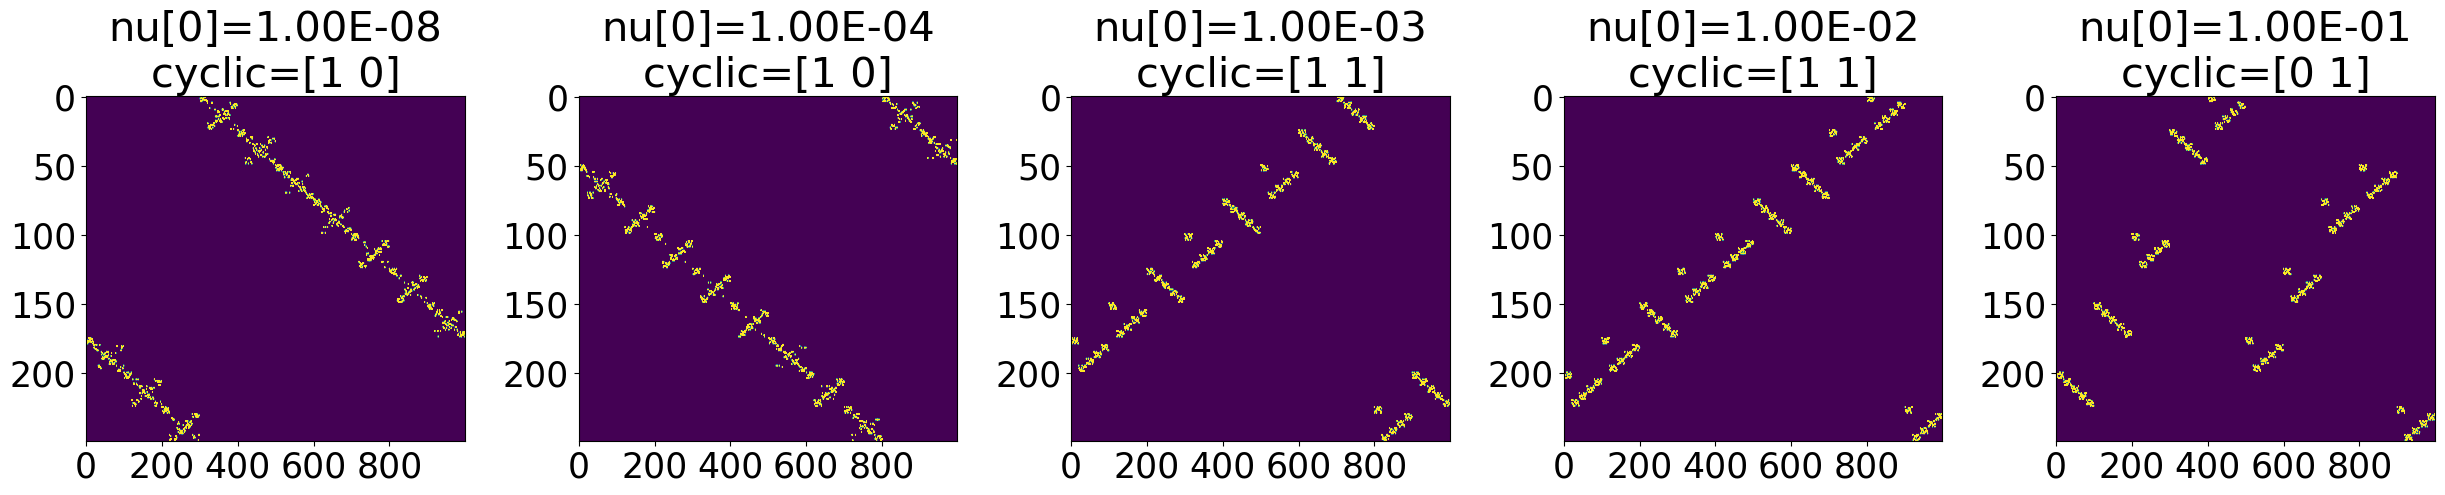

In [17]:
nus_plot = [4, 12, 14, 16, 18]
num_plots = len(nus_plot)

with rc_context({"font.size": 25}):
    scale = 5
    fig, axes = plt.subplots(
        1, num_plots, figsize=(scale * num_plots, scale + 0.5), sharey=False
    )
    for idx in range(num_plots):
        # Find index in global nu list
        idv = nus_plot[idx]

        # Load coupling and find at which levels it's cyclic
        T = Ts_nu[idv]
        cyclic = cyclic_by_levels(Trees_nu[idv])

        # Plot
        im = axes[idx].imshow(
            T,
            vmin=0,
            vmax=0.0001,
            # Plots matrices as squares
            aspect="auto",
            # Pixels are enlarged to improve visibility
            interpolation="auto",
            interpolation_stage="data",
        )

        axes[idx].set_title("nu[0]=%0.2E\ncyclic=%s" % (nus[idv, 0], str(cyclic)))

    # Save for publication
    plt.tight_layout()
    plt.savefig(
        Path(folder_figs, "Nested_2_cycles_MS_2_small.pdf"), bbox_inches="tight"
    )

## Multiscale distance, 3 levels

For comparison, what happens if we use triplets of heat kernels instead of pairs? Let's add the heat kernel at time `t=100`.

In [18]:
# Select times
Times_nu = [50, 100, 200]
I_nu = np.where(np.isin(Times_all, Times_nu))[0]

# Search over nu
nu_log_0 = -5
nNus_0 = 5
nus_0 = np.logspace(nu_log_0, 0, nNus_0 + 1)
# Remove 10^0
nus_0 = np.delete(nus_0, -1)

print(nus_0)
print()

[nus_1, nus_2] = np.meshgrid(nus_0, nus_0)
nus_1 = np.reshape(nus_1, (-1, 1))
nus_2 = np.reshape(nus_2, (-1, 1))
nus_3 = 1 - (nus_1 + nus_2)

# Vary weights on the 3 elements
nus_v3 = np.concatenate(
    (
        np.concatenate((nus_1, nus_2, nus_3), 1),
        np.concatenate((nus_1, nus_3, nus_2), 1),
        np.concatenate((nus_3, nus_1, nus_2), 1),
    ),
    axis=0,
)

nNus = nus_v3.shape[0]
print("nNus:", nNus)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

nNus: 75


In [19]:
# dMS -- vary nu
dMS_nu_v3 = np.zeros(nNus)
Ts_nu_v3 = np.zeros(nNus, dtype=object)
Trees_nu_v3 = []

for idv in range(nNus):
    print("nu %i/%i" % (idv + 1, nNus))
    with np.printoptions(precision=3):
        print(nus_v3[idv, :])

    # Load cost matrices and nu
    nu = nus_v3[idv, :]
    H1 = [Hs_all[0][idt] for idt in I_nu]
    H2 = [Hs_all[1][idt] for idt in I_nu]

    # dMS
    time_start = time()
    T, log = gromov_wasserstein_ms(
        H1, H2, nu=nu, log=True, verbose=0, tol_abs=1e-30, tol_rel=1e-30
    )
    time_end = time()
    print("dMS_nu:" + display_time(time_end - time_start))

    dMS_nu_v3[idv] = 0.5 * np.sqrt(log["gw_dist"])
    Ts_nu_v3[idv] = T

    # Compute block tree
    Trees_nu_v3.append(extract_multiscale_info(T, params2[0], params2[1]))
    print()

nu 1/75
[1.e-05 1.e-05 1.e+00]
dMS_nu:0:00:01.18

nu 2/75
[1.000e-04 1.000e-05 9.999e-01]
dMS_nu:0:00:01.03

nu 3/75
[1.00e-03 1.00e-05 9.99e-01]
dMS_nu:0:00:01.04

nu 4/75
[1.0e-02 1.0e-05 9.9e-01]
dMS_nu:0:00:00.94

nu 5/75
[1.e-01 1.e-05 9.e-01]
dMS_nu:0:00:00.84

nu 6/75
[1.000e-05 1.000e-04 9.999e-01]
dMS_nu:0:00:00.85

nu 7/75
[1.000e-04 1.000e-04 9.998e-01]
dMS_nu:0:00:00.90

nu 8/75
[1.000e-03 1.000e-04 9.989e-01]
dMS_nu:0:00:01.24

nu 9/75
[1.000e-02 1.000e-04 9.899e-01]
dMS_nu:0:00:00.75

nu 10/75
[1.000e-01 1.000e-04 8.999e-01]
dMS_nu:0:00:00.73

nu 11/75
[1.00e-05 1.00e-03 9.99e-01]
dMS_nu:0:00:00.65

nu 12/75
[1.000e-04 1.000e-03 9.989e-01]
dMS_nu:0:00:00.89

nu 13/75
[0.001 0.001 0.998]
dMS_nu:0:00:01.01

nu 14/75
[0.01  0.001 0.989]
dMS_nu:0:00:00.70

nu 15/75
[0.1   0.001 0.899]
dMS_nu:0:00:00.65

nu 16/75
[1.0e-05 1.0e-02 9.9e-01]
dMS_nu:0:00:00.86

nu 17/75
[1.000e-04 1.000e-02 9.899e-01]
dMS_nu:0:00:00.68

nu 18/75
[0.001 0.01  0.989]
dMS_nu:0:00:01.88

nu 19/75
[0.0

The multiscale distance still captures all levels of features; see the graph with `id=7`. In fact, the weight for `t=50` is still `nu[0] = 1e-3`, while the weight for `t=200` is `nu[2] = 1-(1e-3)-(1e-4)`, which is close to `1e-3`.

  0/75 Cyclic: [1 0] (num=1)
  1/75 Cyclic: [1 0] (num=1)
  2/75 Cyclic: [1 0] (num=1)
  3/75 Cyclic: [0 0] (num=0)
  4/75 Cyclic: [0 1] (num=1)
  5/75 Cyclic: [1 0] (num=1)
  6/75 Cyclic: [1 0] (num=1)
  7/75 Cyclic: [1 1] (num=2)
 -- All cyclic! --
  8/75 Cyclic: [0 0] (num=0)
  9/75 Cyclic: [0 1] (num=1)
 10/75 Cyclic: [1 0] (num=1)
 11/75 Cyclic: [1 0] (num=1)
 12/75 Cyclic: [0 1] (num=1)
 13/75 Cyclic: [0 0] (num=0)
 14/75 Cyclic: [0 1] (num=1)
 15/75 Cyclic: [1 0] (num=1)
 16/75 Cyclic: [1 0] (num=1)
 17/75 Cyclic: [1 0] (num=1)
 18/75 Cyclic: [0 0] (num=0)
 19/75 Cyclic: [0 1] (num=1)
 20/75 Cyclic: [0 0] (num=0)
 21/75 Cyclic: [0 0] (num=0)
 22/75 Cyclic: [0 0] (num=0)
 23/75 Cyclic: [0 0] (num=0)
 24/75 Cyclic: [0 1] (num=1)
 25/75 Cyclic: [0 0] (num=0)
 26/75 Cyclic: [0 0] (num=0)
 27/75 Cyclic: [0 0] (num=0)
 28/75 Cyclic: [0 0] (num=0)
 29/75 Cyclic: [0 1] (num=1)
 30/75 Cyclic: [0 0] (num=0)
 31/75 Cyclic: [0 0] (num=0)
 32/75 Cyclic: [0 0] (num=0)
 33/75 Cyclic: [0 0] (nu

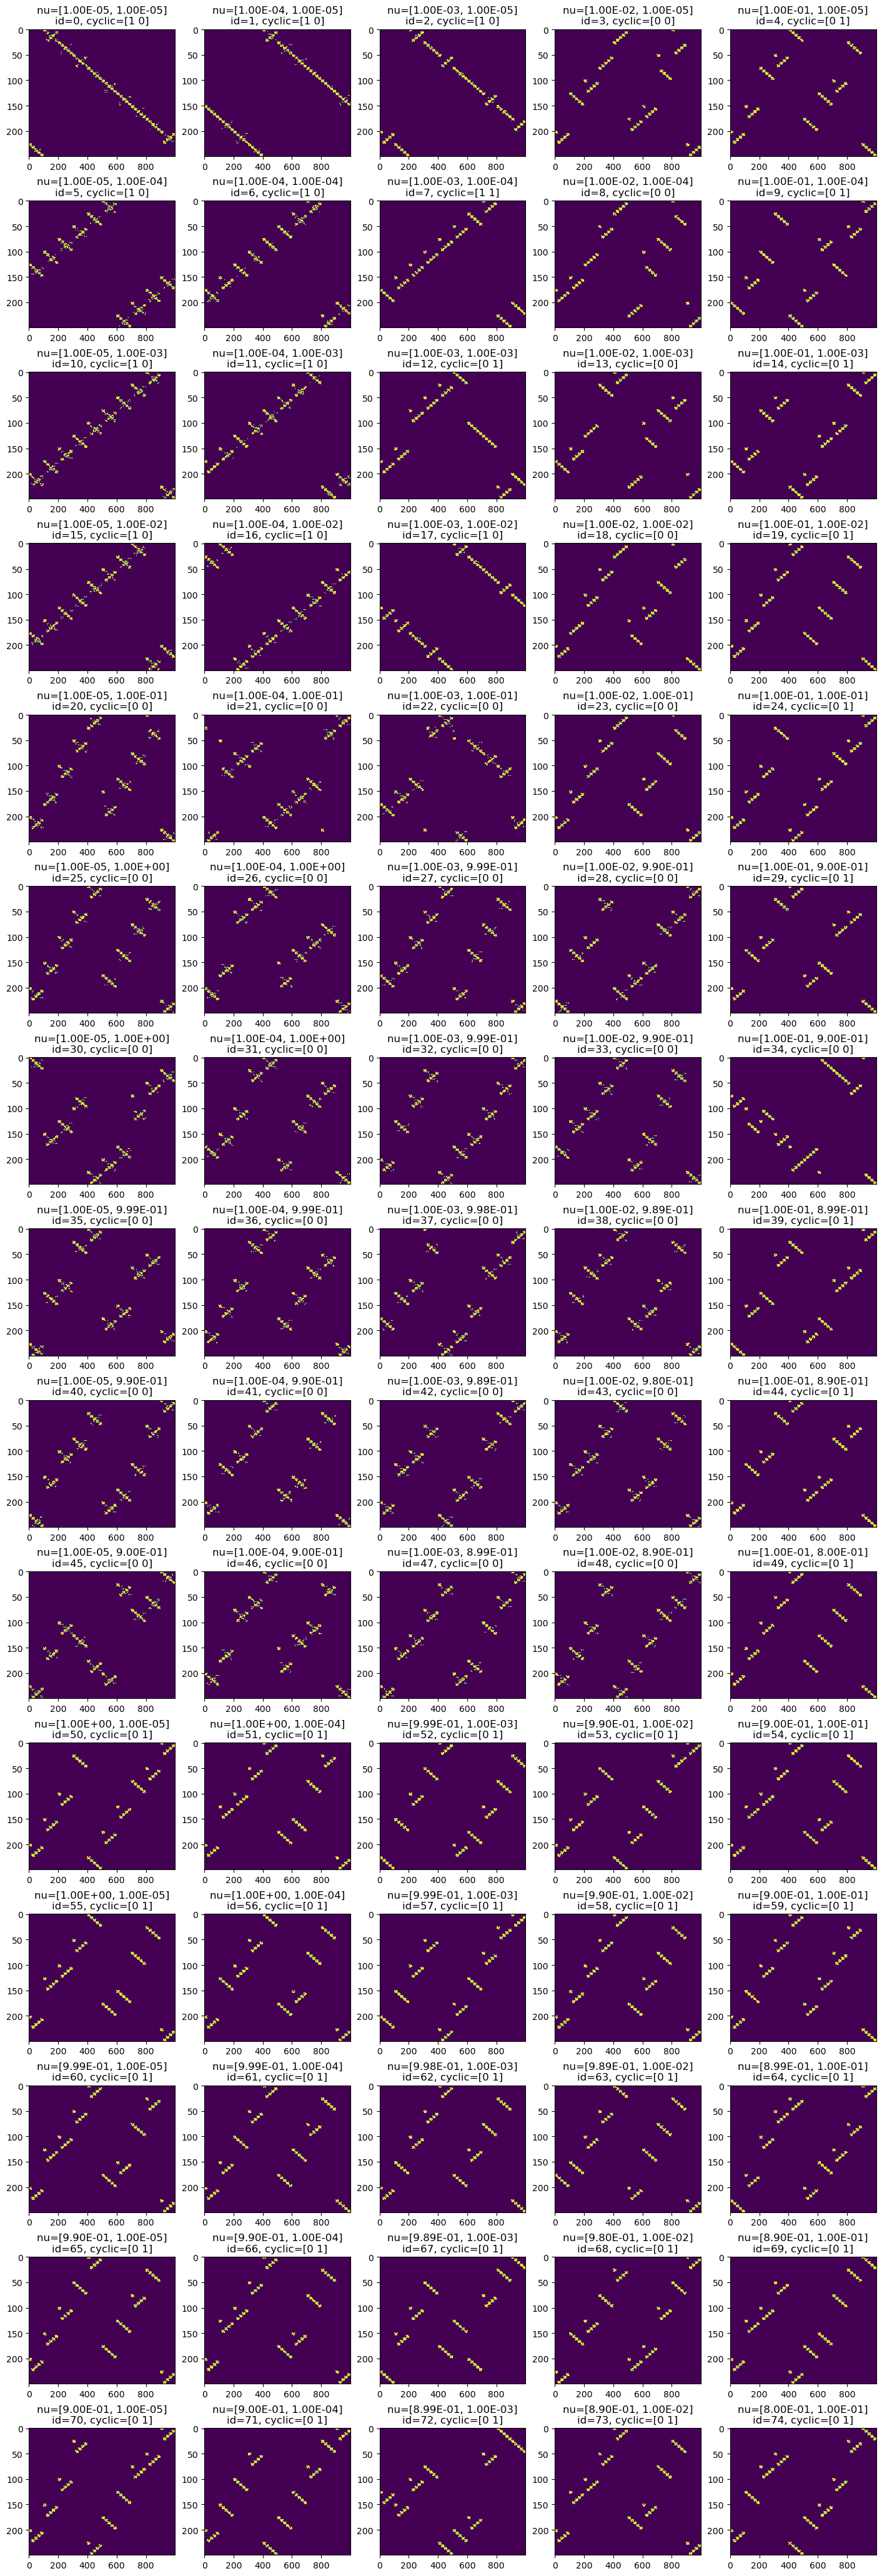

In [20]:
cols = np.min([nNus, 5])
ps = [int(np.ceil(nNus / cols)), cols]
fig, axes = plt.subplots(ps[0], ps[1], figsize=(3.5 * ps[1], 3.5 * ps[0]))
plt.subplots_adjust(hspace=0.35)

# Plot all couplings with the same colorbar
for idv in range(nNus):
    T = Ts_nu_v3[idv]
    cyclic = cyclic_by_levels(Trees_nu_v3[idv])

    if ps[0] > 1:
        [r, c] = np.unravel_index(idv, ps)
        sp_idx = [r, c]
    else:
        sp_idx = [idt]

    im = axes[*sp_idx].imshow(
        T,
        vmin=0,
        vmax=0.0001,
        # Plots matrices as squares
        aspect="auto",
        # Pixels are enlarged to improve visibility
        interpolation="auto",
        interpolation_stage="data",
    )

    # axes[*sp_idx].set_title('nus=[%0.2E, %0.2E, %0.2E]' % tuple(nus_v3[idv,:]) )
    axes[*sp_idx].set_title(
        "nu=[%0.2E, %0.2E]\nid=%i, cyclic=%s" % (*nus_v3[idv, :-1], idv, str(cyclic))
    )

    print("{:3d}/{} Cyclic: {} (num={})".format(idv, nNus, str(cyclic), np.sum(cyclic)))
    if all(cyclic):
        print(f" -- All cyclic! --")

### Format graphs for paper

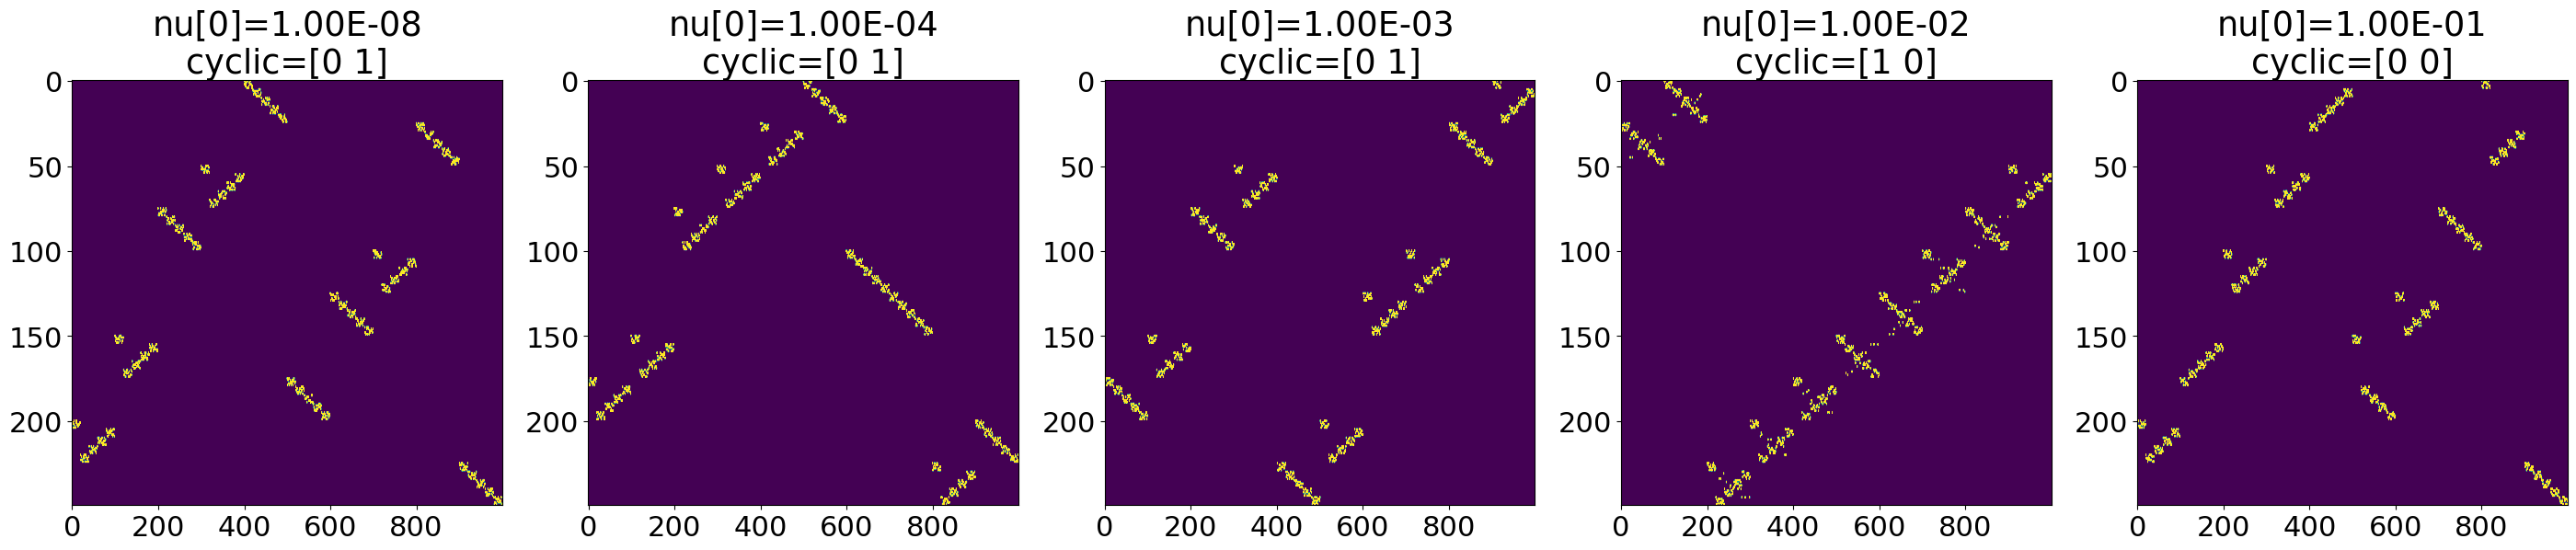

In [21]:
nus_plot = [4, 12, 14, 16, 18]
num_plots = len(nus_plot)

with rc_context({"font.size": 22}):
    scale = 6
    fig, axes = plt.subplots(1, num_plots, figsize=(scale * num_plots + 5, scale))
    for idx in range(num_plots):
        # Find index in global nu list
        idv = nus_plot[idx]

        # Load coupling and find at which levels it's cyclic
        T = Ts_nu_v3[idv]
        cyclic = cyclic_by_levels(Trees_nu_v3[idv])

        # Plot
        im = axes[idx].imshow(
            T,
            vmin=0,
            vmax=0.0001,
            # Plots matrices as squares
            aspect="auto",
            # Pixels are enlarged to improve visibility
            interpolation="auto",
            interpolation_stage="data",
        )

        axes[idx].set_title("nu[0]=%0.2E\ncyclic=%s" % (nus[idv, 0], str(cyclic)))

    # Save for publication
    # plt.tight_layout()
    # plt.savefig(
    #     Path(folder_figs, 'Nested_2_cycles_MS_2_small.pdf'),
    #     bbox_inches='tight'
    #     )

# Heat kernels of 3-nested cycles

We repeat the experiment but with 3-nested cycles of cliques. We don't expect the GW distance or even the parametrized GW distance between pairs of heat kernels to capture all 3 levels of features. We need the parametrized GW distance between triplets of heat kernels.

## Generate graphs

In [22]:
params3 = [[4, 4, 4, 5], [4, 4, 4, 20]]
nGraphs3 = len(params3)

# Create figure if we want to see the graphs
plot = False
if plot:
    fig, axes = plt.subplots(1, nGraphs3, figsize=(20, 5))

Graphs3 = []
for idx, param in enumerate(params3):
    G = nested_cycles(*param)
    Graphs3.append(G)
    print("n_nodes:", G.number_of_nodes())

    if plot:
        pos = pos_nested_cycles(*param, scale=5)
        nx.draw(G, ax=axes[idx], pos=pos)

n_nodes: 320
n_nodes: 1280


## Generate heat kernels

In [23]:
normalize = True
scale_0 = False
compute_diagonal = False

step0 = 10
step_size = 10
n_times = 50
Times_all = step0 + np.arange(0, n_times * step_size, step_size)
print(Times_all)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400 410 420 430 440 450 460 470 480 490 500]


In [24]:
# For each graph, generate heat kernels for all times
Hs_all = []

for idg in range(nGraphs3):
    G = Graphs3[idg]

    H_G = []
    for idt in range(n_times):
        time_start = time()

        t = Times_all[idt]
        H = heat_kernel(G, t)

        if normalize:
            H /= np.linalg.norm(H)
        H_G.append(H)

        time_end = time()
        print(
            "(%i, %i)/(%i, %i): %s"
            % (
                idg + 1,
                idt + 1,
                nGraphs3,
                n_times,
                display_time(time_end - time_start),
            )
        )

    Hs_all.append(H_G)

(1, 1)/(2, 50): 0:00:00.02
(1, 2)/(2, 50): 0:00:00.01
(1, 3)/(2, 50): 0:00:00.01
(1, 4)/(2, 50): 0:00:00.01
(1, 5)/(2, 50): 0:00:00.01
(1, 6)/(2, 50): 0:00:00.01
(1, 7)/(2, 50): 0:00:00.01
(1, 8)/(2, 50): 0:00:00.01
(1, 9)/(2, 50): 0:00:00.01
(1, 10)/(2, 50): 0:00:00.01
(1, 11)/(2, 50): 0:00:00.01
(1, 12)/(2, 50): 0:00:00.01
(1, 13)/(2, 50): 0:00:00.01
(1, 14)/(2, 50): 0:00:00.01
(1, 15)/(2, 50): 0:00:00.01
(1, 16)/(2, 50): 0:00:00.01
(1, 17)/(2, 50): 0:00:00.01
(1, 18)/(2, 50): 0:00:00.01
(1, 19)/(2, 50): 0:00:00.02
(1, 20)/(2, 50): 0:00:00.01
(1, 21)/(2, 50): 0:00:00.01
(1, 22)/(2, 50): 0:00:00.01
(1, 23)/(2, 50): 0:00:00.01
(1, 24)/(2, 50): 0:00:00.01
(1, 25)/(2, 50): 0:00:00.01
(1, 26)/(2, 50): 0:00:00.01
(1, 27)/(2, 50): 0:00:00.01
(1, 28)/(2, 50): 0:00:00.01
(1, 29)/(2, 50): 0:00:00.01
(1, 30)/(2, 50): 0:00:00.01
(1, 31)/(2, 50): 0:00:00.02
(1, 32)/(2, 50): 0:00:00.01
(1, 33)/(2, 50): 0:00:00.01
(1, 34)/(2, 50): 0:00:00.01
(1, 35)/(2, 50): 0:00:00.01
(1, 36)/(2, 50): 0:00:00.02
(

## GW distance

In [25]:
# Compute dGW between at step
dGW_all = np.zeros(n_times)
Ts_all = np.zeros(n_times, dtype=object)
Trees_all = []

for idt in range(n_times):
    print("Step: %i/%i" % (idt + 1, n_times))

    H1 = Hs_all[0][idt]
    H2 = Hs_all[1][idt]

    time_start = time()
    T, log = gromov_wasserstein(
        H1, H2, log=True, verbose=0, tol_abs=1e-30, tol_rel=1e-30
    )
    time_end = time()
    print("Time: " + display_time(time_end - time_start))
    print()

    dGW_all[idt] = 0.5 * np.sqrt(log["gw_dist"])
    Ts_all[idt] = T

    # Block tree
    Trees_all.append(extract_multiscale_info(T, params3[0], params3[1]))

Step: 1/50
Time: 0:00:00.39

Step: 2/50
Time: 0:00:00.74

Step: 3/50
Time: 0:00:00.67

Step: 4/50
Time: 0:00:00.48

Step: 5/50
Time: 0:00:00.57

Step: 6/50
Time: 0:00:00.53

Step: 7/50
Time: 0:00:00.57

Step: 8/50
Time: 0:00:01.03

Step: 9/50
Time: 0:00:00.77

Step: 10/50
Time: 0:00:00.76

Step: 11/50
Time: 0:00:01.05

Step: 12/50
Time: 0:00:01.11

Step: 13/50
Time: 0:00:00.49

Step: 14/50
Time: 0:00:00.54

Step: 15/50
Time: 0:00:00.51

Step: 16/50
Time: 0:00:00.53

Step: 17/50
Time: 0:00:00.52

Step: 18/50
Time: 0:00:00.82

Step: 19/50
Time: 0:00:00.41

Step: 20/50
Time: 0:00:00.87

Step: 21/50
Time: 0:00:00.59

Step: 22/50
Time: 0:00:00.45

Step: 23/50
Time: 0:00:00.48

Step: 24/50
Time: 0:00:00.70

Step: 25/50
Time: 0:00:00.77

Step: 26/50
Time: 0:00:00.50

Step: 27/50
Time: 0:00:00.54

Step: 28/50
Time: 0:00:00.69

Step: 29/50
Time: 0:00:00.45

Step: 30/50
Time: 0:00:00.53

Step: 31/50
Time: 0:00:00.38

Step: 32/50
Time: 0:00:00.54

Step: 33/50
Time: 0:00:00.38

Step: 34/50
Time: 0

  0/50 Cyclic: [0 0 0] (num=0)
  1/50 Cyclic: [0 0 1] (num=1)
  2/50 Cyclic: [0 0 1] (num=1)
  3/50 Cyclic: [0 0 0] (num=0)
  4/50 Cyclic: [0 0 0] (num=0)
  5/50 Cyclic: [0 0 0] (num=0)
  6/50 Cyclic: [0 0 0] (num=0)
  7/50 Cyclic: [0 0 0] (num=0)
  8/50 Cyclic: [0 0 0] (num=0)
  9/50 Cyclic: [0 1 0] (num=1)
 10/50 Cyclic: [0 1 0] (num=1)
 11/50 Cyclic: [0 1 0] (num=1)
 12/50 Cyclic: [0 1 0] (num=1)
 13/50 Cyclic: [0 1 0] (num=1)
 14/50 Cyclic: [0 1 0] (num=1)
 15/50 Cyclic: [0 1 0] (num=1)
 16/50 Cyclic: [0 1 0] (num=1)
 17/50 Cyclic: [0 1 0] (num=1)
 18/50 Cyclic: [0 1 0] (num=1)
 19/50 Cyclic: [0 1 0] (num=1)
 20/50 Cyclic: [0 1 0] (num=1)
 21/50 Cyclic: [0 1 0] (num=1)
 22/50 Cyclic: [0 1 0] (num=1)
 23/50 Cyclic: [0 1 0] (num=1)
 24/50 Cyclic: [0 1 0] (num=1)
 25/50 Cyclic: [0 1 0] (num=1)
 26/50 Cyclic: [0 1 0] (num=1)
 27/50 Cyclic: [0 1 0] (num=1)
 28/50 Cyclic: [0 0 0] (num=0)
 29/50 Cyclic: [0 0 0] (num=0)
 30/50 Cyclic: [0 0 0] (num=0)
 31/50 Cyclic: [0 0 0] (num=0)
 32/50 C

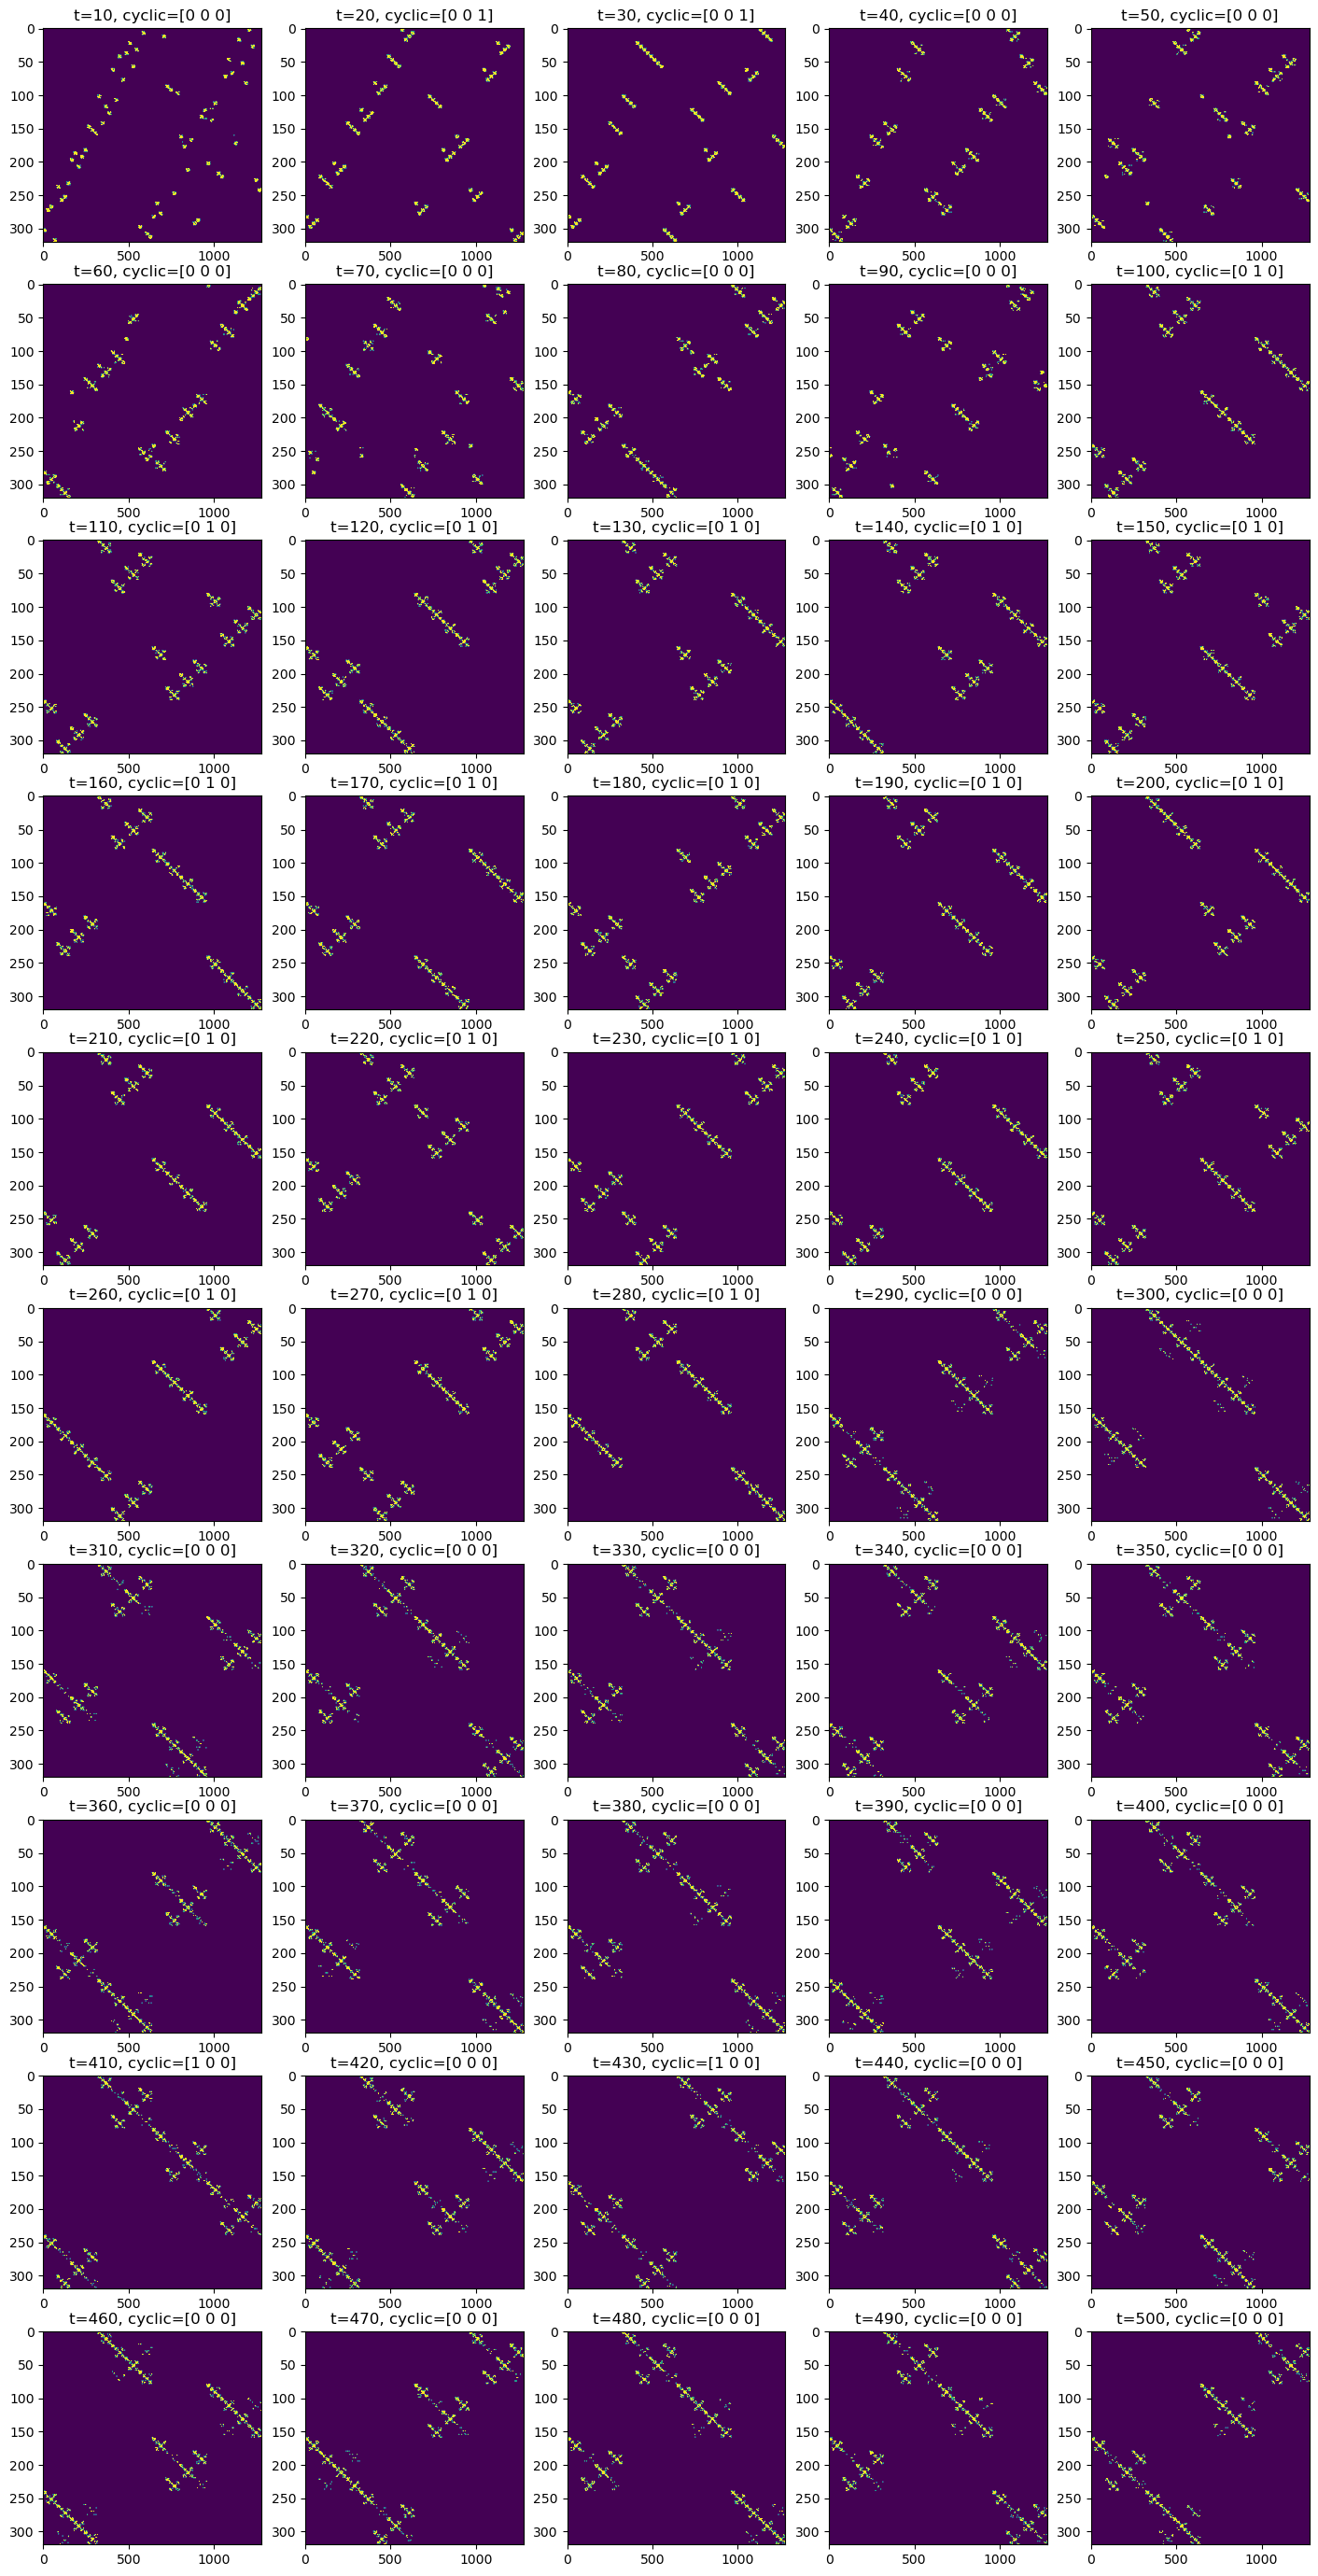

In [26]:
cols = np.min([n_times, 5])
ps = [int(np.ceil(n_times / cols)), cols]
fig, axes = plt.subplots(ps[0], ps[1], figsize=(3.5 * ps[1], 3.5 * ps[0]))

# Plot all couplings with the same colorbar
for idt in range(n_times):
    T = Ts_all[idt]
    cyclic = cyclic_by_levels(Trees_all[idt])

    if ps[0] > 1:
        [r, c] = np.unravel_index(idt, ps)
        sp_idx = [r, c]
    else:
        sp_idx = [idt]

    im = axes[*sp_idx].imshow(
        T,
        vmin=0,
        vmax=0.0001,
        # Plots matrices as squares
        aspect="auto",
        # Pixels are enlarged to improve visibility
        interpolation="auto",
        interpolation_stage="data",
    )
    axes[*sp_idx].set_title("t=%i, cyclic=%s" % (Times_all[idt], str(cyclic)))

    print(
        "{:3d}/{} Cyclic: {} (num={})".format(idt, n_times, str(cyclic), np.sum(cyclic))
    )
    if all(cyclic):
        print(f" -- All cyclic! --")

### Format graphs for paper

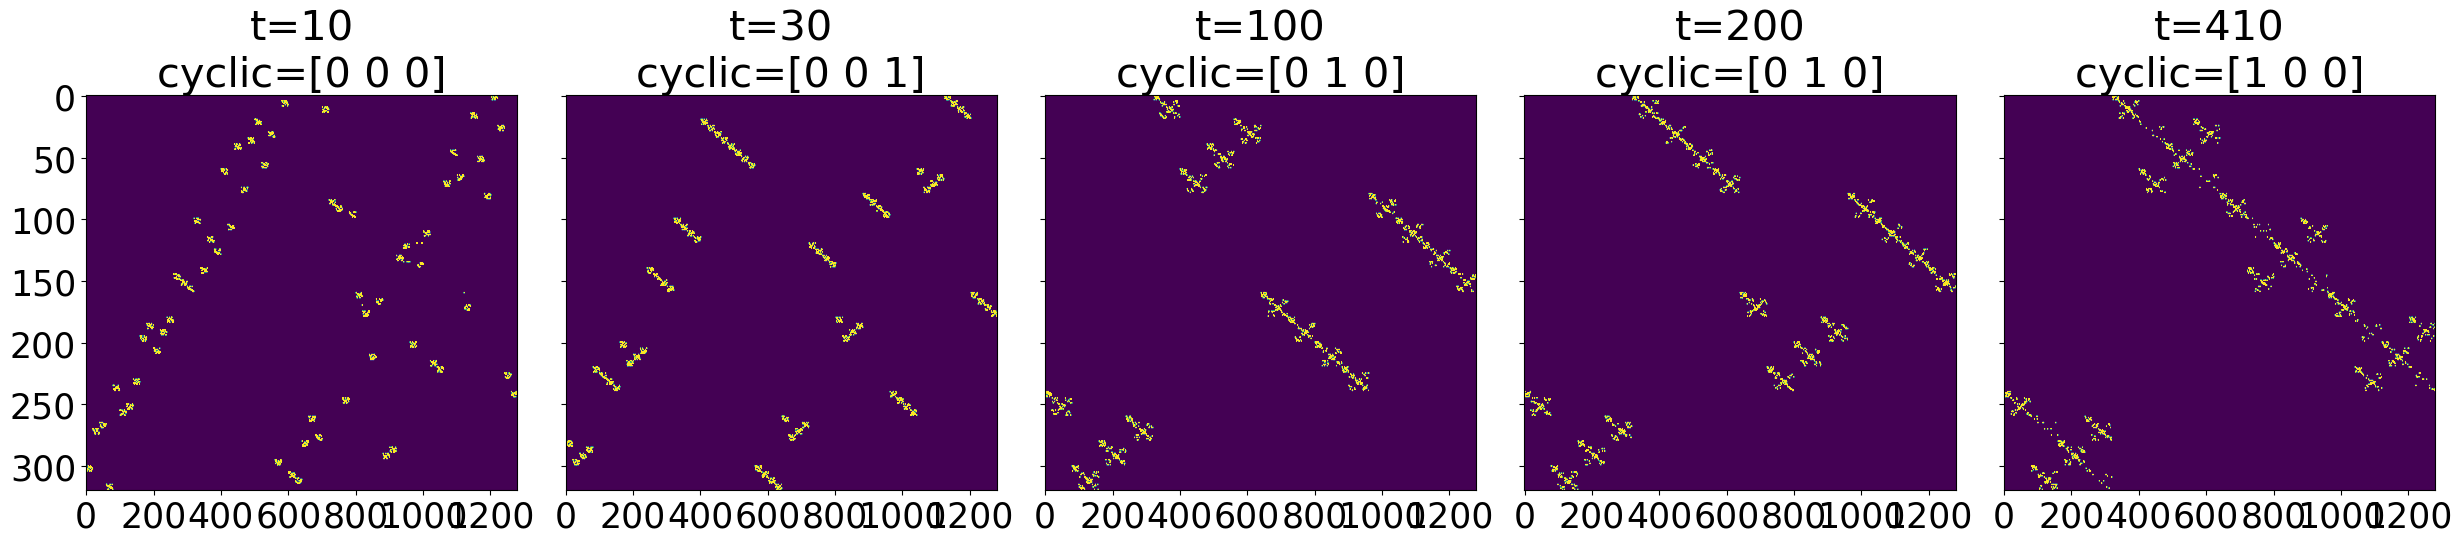

In [27]:
Times_plot = [10, 30, 100, 200, 410]
num_plots = len(Times_plot)

with rc_context({"font.size": 25}):
    scale = 5
    fig, axes = plt.subplots(
        1, num_plots, figsize=(scale * num_plots, scale + 1), sharey=True
    )
    for idx in range(num_plots):
        # Find index in global times list
        idt = np.where(Times_all == Times_plot[idx])[0][0]

        # Load coupling and find at which levels it's cyclic
        T = Ts_all[idt]
        cyclic = cyclic_by_levels(Trees_all[idt])

        # Plot
        im = axes[idx].imshow(
            T,
            vmin=0,
            vmax=0.0001,
            # Plots matrices as squares
            aspect="auto",
            # Pixels are enlarged to improve visibility
            interpolation="auto",
            interpolation_stage="data",
        )
        axes[idx].set_title("t=%i\ncyclic=%s" % (Times_all[idt], str(cyclic)))

    # Save for publication
    plt.tight_layout()
    plt.savefig(Path(folder_figs, "Nested_3_cycles_GW.pdf"), bbox_inches="tight")

## Multiscale distance, 2 levels
2 heat kernels are not enough

In [28]:
# Sample probability measures spaced exponentially
nus_v2 = sampling_simplex_log(10, 2, n_samples=13)
nNus_v2 = nus_v2.shape[0]

# Select times
Times_nu_v2 = [30, 200]
I_nu_v2 = np.where(np.isin(Times_all, Times_nu_v2))[0]

print("nNus:", nNus_v2)

nNus: 77


In [29]:
# dMS -- vary nu
dMS_nu_v2 = np.zeros(nNus_v2)
Ts_nu_v2 = np.zeros(nNus_v2, dtype=object)
Trees_nu_v2 = []

for idv in range(nNus_v2):
    print("nu %i/%i" % (idv + 1, nNus_v2))
    with np.printoptions(precision=3, suppress=False):
        print(nus_v2[idv, :])

    # Load cost matrices and nu
    nu = nus_v2[idv, :]
    H1 = [Hs_all[0][idt] for idt in I_nu_v2]
    H2 = [Hs_all[1][idt] for idt in I_nu_v2]

    # dMS
    time_start = time()
    T, log = gromov_wasserstein_ms(
        H1, H2, nu=nu, log=True, verbose=0, tol_abs=1e-30, tol_rel=1e-30
    )
    time_end = time()
    print("dMS_nu:" + display_time(time_end - time_start))

    dMS_nu_v2[idv] = 0.5 * np.sqrt(log["gw_dist"])
    Ts_nu_v2[idv] = T

    # Compute block tree
    Trees_nu_v2.append(extract_multiscale_info(T, params3[0], params3[1]))
    print()

nu 1/77
[1.e-09 1.e+00]
dMS_nu:0:00:01.00

nu 2/77
[5.623e-09 1.000e+00]
dMS_nu:0:00:00.84

nu 3/77
[5.623e-09 1.000e+00]
dMS_nu:0:00:00.95

nu 4/77
[3.162e-08 1.000e+00]
dMS_nu:0:00:00.93

nu 5/77
[3.162e-08 1.000e+00]
dMS_nu:0:00:00.97

nu 6/77
[1.778e-07 1.000e+00]
dMS_nu:0:00:01.19

nu 7/77
[1.778e-07 1.000e+00]
dMS_nu:0:00:01.29

nu 8/77
[1.778e-07 1.000e+00]
dMS_nu:0:00:01.17

nu 9/77
[1.e-06 1.e+00]
dMS_nu:0:00:01.31

nu 10/77
[5.623e-06 1.000e+00]
dMS_nu:0:00:01.39

nu 11/77
[5.623e-06 1.000e+00]
dMS_nu:0:00:01.39

nu 12/77
[5.623e-06 1.000e+00]
dMS_nu:0:00:01.43

nu 13/77
[5.623e-06 1.000e+00]
dMS_nu:0:00:01.32

nu 14/77
[3.162e-05 1.000e+00]
dMS_nu:0:00:01.39

nu 15/77
[3.162e-05 1.000e+00]
dMS_nu:0:00:00.79

nu 16/77
[3.162e-05 1.000e+00]
dMS_nu:0:00:01.43

nu 17/77
[3.162e-05 1.000e+00]
dMS_nu:0:00:01.13

nu 18/77
[1.778e-04 9.998e-01]
dMS_nu:0:00:01.15

nu 19/77
[1.778e-04 9.998e-01]
dMS_nu:0:00:01.05

nu 20/77
[1.778e-04 9.998e-01]
dMS_nu:0:00:01.27

nu 21/77
[9.99e-04 9.

  0/77 Cyclic: [0 1 0] (num=1)
  1/77 Cyclic: [0 1 0] (num=1)
  2/77 Cyclic: [0 1 0] (num=1)
  3/77 Cyclic: [0 1 0] (num=1)
  4/77 Cyclic: [0 1 0] (num=1)
  5/77 Cyclic: [0 1 0] (num=1)
  6/77 Cyclic: [0 1 0] (num=1)
  7/77 Cyclic: [0 1 0] (num=1)
  8/77 Cyclic: [0 1 0] (num=1)
  9/77 Cyclic: [0 1 0] (num=1)
 10/77 Cyclic: [0 1 0] (num=1)
 11/77 Cyclic: [0 1 0] (num=1)
 12/77 Cyclic: [0 1 0] (num=1)
 13/77 Cyclic: [0 1 0] (num=1)
 14/77 Cyclic: [0 1 0] (num=1)
 15/77 Cyclic: [0 1 0] (num=1)
 16/77 Cyclic: [0 1 0] (num=1)
 17/77 Cyclic: [0 1 1] (num=2)
 18/77 Cyclic: [0 1 1] (num=2)
 19/77 Cyclic: [0 1 1] (num=2)
 20/77 Cyclic: [0 1 1] (num=2)
 21/77 Cyclic: [0 1 1] (num=2)
 22/77 Cyclic: [0 1 1] (num=2)
 23/77 Cyclic: [0 1 1] (num=2)
 24/77 Cyclic: [0 1 1] (num=2)
 25/77 Cyclic: [0 1 1] (num=2)
 26/77 Cyclic: [0 1 1] (num=2)
 27/77 Cyclic: [0 1 1] (num=2)
 28/77 Cyclic: [0 0 1] (num=1)
 29/77 Cyclic: [0 0 1] (num=1)
 30/77 Cyclic: [1 0 1] (num=2)
 31/77 Cyclic: [0 0 1] (num=1)
 32/77 C

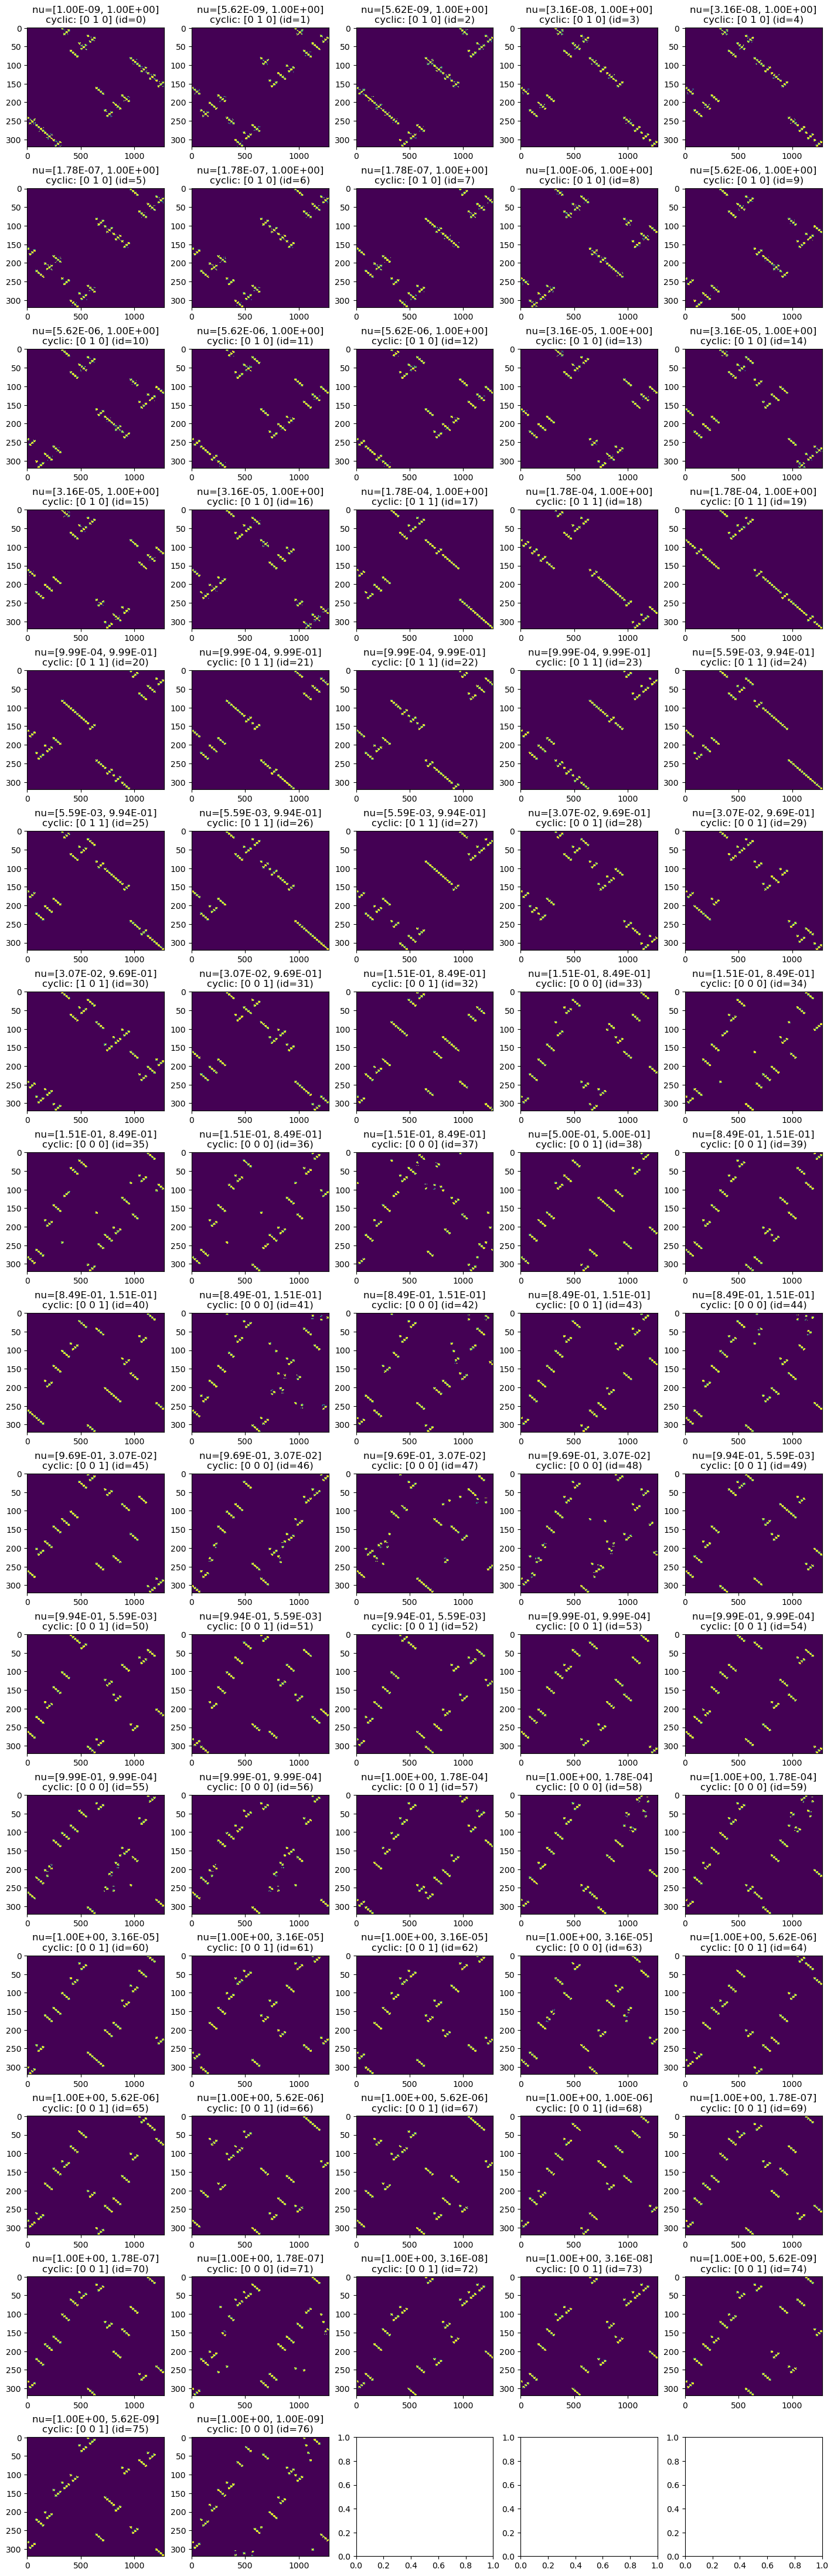

In [30]:
cols = np.min([nNus_v2, 5])
ps = [int(np.ceil(nNus_v2 / cols)), cols]
fig, axes = plt.subplots(ps[0], ps[1], figsize=(3.5 * ps[1], 3.5 * ps[0]))
plt.subplots_adjust(hspace=0.35)

# Plot all couplings with the same colorbar
for idv in range(nNus_v2):
    T = Ts_nu_v2[idv]
    cyclic = cyclic_by_levels(Trees_nu_v2[idv])

    if ps[0] > 1:
        [r, c] = np.unravel_index(idv, ps)
        sp_idx = [r, c]
    else:
        sp_idx = [idt]
    im = axes[*sp_idx].imshow(
        T,
        vmin=0,
        vmax=0.0001,
        # Plots matrices as squares
        aspect="auto",
        # Pixels are enlarged to improve visibility
        interpolation="auto",
        interpolation_stage="data",
    )

    # axes[*sp_idx].set_title('nus=[%0.2E, %0.2E, %0.2E]' % tuple(nus_v2[idv,:]) )
    axes[*sp_idx].set_title(
        "nu=[%0.2E, %0.2E]\ncyclic: %s (id=%i)" % (*nus_v2[idv, :], str(cyclic), idv)
    )

    print(
        "{:3d}/{} Cyclic: {} (num={})".format(idv, nNus_v2, str(cyclic), np.sum(cyclic))
    )
    if all(cyclic):
        print(f" -- All cyclic! --")

## Multiscale distance, 3 levels
We need triplets of heat kernels

In [31]:
# Sample probability measures spaced exponentially
nus_v3 = sampling_simplex_log(6, 3, n_samples=10)
# nus_v3 = sampling_simplex_log(5, 3)

# Manually restrict to a range of exponents
subset = np.logical_and(1e-4 <= nus_v3[:, 0], nus_v3[:, 0] < 10 ** (-3.5))
nus_v3 = nus_v3[subset, :]

nNus_v3 = nus_v3.shape[0]

# Select times
Times_nu_v3 = [30, 100, 410]

I_nu_v3 = np.where(np.isin(Times_all, Times_nu_v3))[0]

print(nus_v3)
print("nNus:", nNus_v3)

[[1.01029781e-04 2.17662065e-01 7.82236905e-01]
 [1.01029781e-04 7.82236905e-01 2.17662065e-01]
 [1.01029781e-04 2.17662065e-01 7.82236905e-01]
 [1.01029781e-04 7.82236905e-01 2.17662065e-01]
 [1.01029781e-04 7.82236905e-01 2.17662065e-01]
 [1.01029781e-04 2.17662065e-01 7.82236905e-01]
 [1.19859222e-04 7.18537157e-02 9.28026425e-01]
 [1.19859222e-04 9.28026425e-01 7.18537157e-02]
 [1.19859222e-04 7.18537157e-02 9.28026425e-01]
 [1.19859222e-04 9.28026425e-01 7.18537157e-02]
 [1.19859222e-04 9.28026425e-01 7.18537157e-02]
 [1.19859222e-04 7.18537157e-02 9.28026425e-01]
 [1.26415108e-04 2.10873110e-02 9.78786274e-01]
 [1.26415108e-04 9.78786274e-01 2.10873110e-02]
 [1.26415108e-04 2.10873110e-02 9.78786274e-01]
 [1.26415108e-04 9.78786274e-01 2.10873110e-02]
 [1.26415108e-04 2.10873110e-02 9.78786274e-01]
 [1.26415108e-04 9.78786274e-01 2.10873110e-02]
 [1.28368836e-04 5.95835356e-03 9.93913278e-01]
 [1.28368836e-04 9.93913278e-01 5.95835356e-03]
 [1.28368836e-04 5.95835356e-03 9.939132

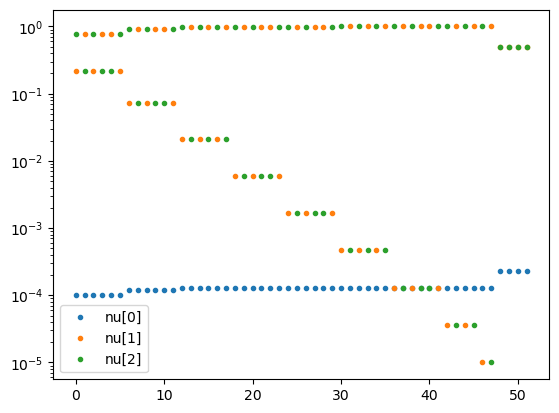

In [32]:
plt.plot(nus_v3, ".")
plt.yscale("log")
plt.legend(["nu[%i]" % i for i in range(3)])

In [33]:
# dMS -- vary nu
dMS_nu_v3 = np.zeros(nNus_v3)
Ts_nu_v3 = np.zeros(nNus_v3, dtype=object)
Trees_nu_v3 = []

for idv in range(nNus_v3):
    print("nu %i/%i" % (idv + 1, nNus_v3))
    with np.printoptions(precision=3, suppress=False):
        print(nus_v3[idv, :])

    # Load cost matrices and nu
    nu = nus_v3[idv, :]
    H1 = [Hs_all[0][idt] for idt in I_nu_v3]
    H2 = [Hs_all[1][idt] for idt in I_nu_v3]

    # dMS
    time_start = time()
    T, log = gromov_wasserstein_ms(
        H1,
        H2,
        nu=nu,
        log=True,
        verbose=0,
        max_iter=1e3,
        numItermaxEmd=1e5,
        tol_abs=1e-30,
        tol_rel=1e-30,
    )
    time_end = time()
    print("dMS_nu:" + display_time(time_end - time_start))

    # Remove noise from T
    # T = T - T*(T<1e-15)

    dMS_nu_v3[idv] = 0.5 * np.sqrt(log["gw_dist"])
    Ts_nu_v3[idv] = T

    # Compute block tree
    Trees_nu_v3.append(extract_multiscale_info(T, params3[0], params3[1]))
    print()

nu 1/52
[1.010e-04 2.177e-01 7.822e-01]
dMS_nu:0:00:02.96

nu 2/52
[1.010e-04 7.822e-01 2.177e-01]
dMS_nu:0:00:02.42

nu 3/52
[1.010e-04 2.177e-01 7.822e-01]
dMS_nu:0:00:01.99

nu 4/52
[1.010e-04 7.822e-01 2.177e-01]
dMS_nu:0:00:02.50

nu 5/52
[1.010e-04 7.822e-01 2.177e-01]
dMS_nu:0:00:02.11

nu 6/52
[1.010e-04 2.177e-01 7.822e-01]
dMS_nu:0:00:01.61

nu 7/52
[1.199e-04 7.185e-02 9.280e-01]
dMS_nu:0:00:01.80

nu 8/52
[1.199e-04 9.280e-01 7.185e-02]
dMS_nu:0:00:03.27

nu 9/52
[1.199e-04 7.185e-02 9.280e-01]
dMS_nu:0:00:01.61

nu 10/52
[1.199e-04 9.280e-01 7.185e-02]
dMS_nu:0:00:02.23

nu 11/52
[1.199e-04 9.280e-01 7.185e-02]
dMS_nu:0:00:02.00

nu 12/52
[1.199e-04 7.185e-02 9.280e-01]
dMS_nu:0:00:01.81

nu 13/52
[1.264e-04 2.109e-02 9.788e-01]
dMS_nu:0:00:01.29

nu 14/52
[1.264e-04 9.788e-01 2.109e-02]
dMS_nu:0:00:01.52

nu 15/52
[1.264e-04 2.109e-02 9.788e-01]
dMS_nu:0:00:01.12

nu 16/52
[1.264e-04 9.788e-01 2.109e-02]
dMS_nu:0:00:02.85

nu 17/52
[1.264e-04 2.109e-02 9.788e-01]
dMS_nu:0

  0/52 Cyclic: [0 1 1] (num=2)
  1/52 Cyclic: [0 1 1] (num=2)
  2/52 Cyclic: [0 1 1] (num=2)
  3/52 Cyclic: [0 1 1] (num=2)
  4/52 Cyclic: [0 1 1] (num=2)
  5/52 Cyclic: [0 1 1] (num=2)
  6/52 Cyclic: [0 1 1] (num=2)
  7/52 Cyclic: [0 0 0] (num=0)
  8/52 Cyclic: [0 1 1] (num=2)
  9/52 Cyclic: [0 0 0] (num=0)
 10/52 Cyclic: [0 1 1] (num=2)
 11/52 Cyclic: [0 1 1] (num=2)
 12/52 Cyclic: [0 0 0] (num=0)
 13/52 Cyclic: [0 1 1] (num=2)
 14/52 Cyclic: [0 0 0] (num=0)
 15/52 Cyclic: [0 1 1] (num=2)
 16/52 Cyclic: [0 1 1] (num=2)
 17/52 Cyclic: [0 1 1] (num=2)
 18/52 Cyclic: [0 1 1] (num=2)
 19/52 Cyclic: [0 0 0] (num=0)
 20/52 Cyclic: [0 0 1] (num=1)
 21/52 Cyclic: [0 0 0] (num=0)
 22/52 Cyclic: [0 1 1] (num=2)
 23/52 Cyclic: [0 1 1] (num=2)
 24/52 Cyclic: [0 1 1] (num=2)
 25/52 Cyclic: [0 1 1] (num=2)
 26/52 Cyclic: [0 1 1] (num=2)
 27/52 Cyclic: [0 1 1] (num=2)
 28/52 Cyclic: [0 0 0] (num=0)
 29/52 Cyclic: [0 1 1] (num=2)
 30/52 Cyclic: [0 1 1] (num=2)
 31/52 Cyclic: [0 1 1] (num=2)
 32/52 C

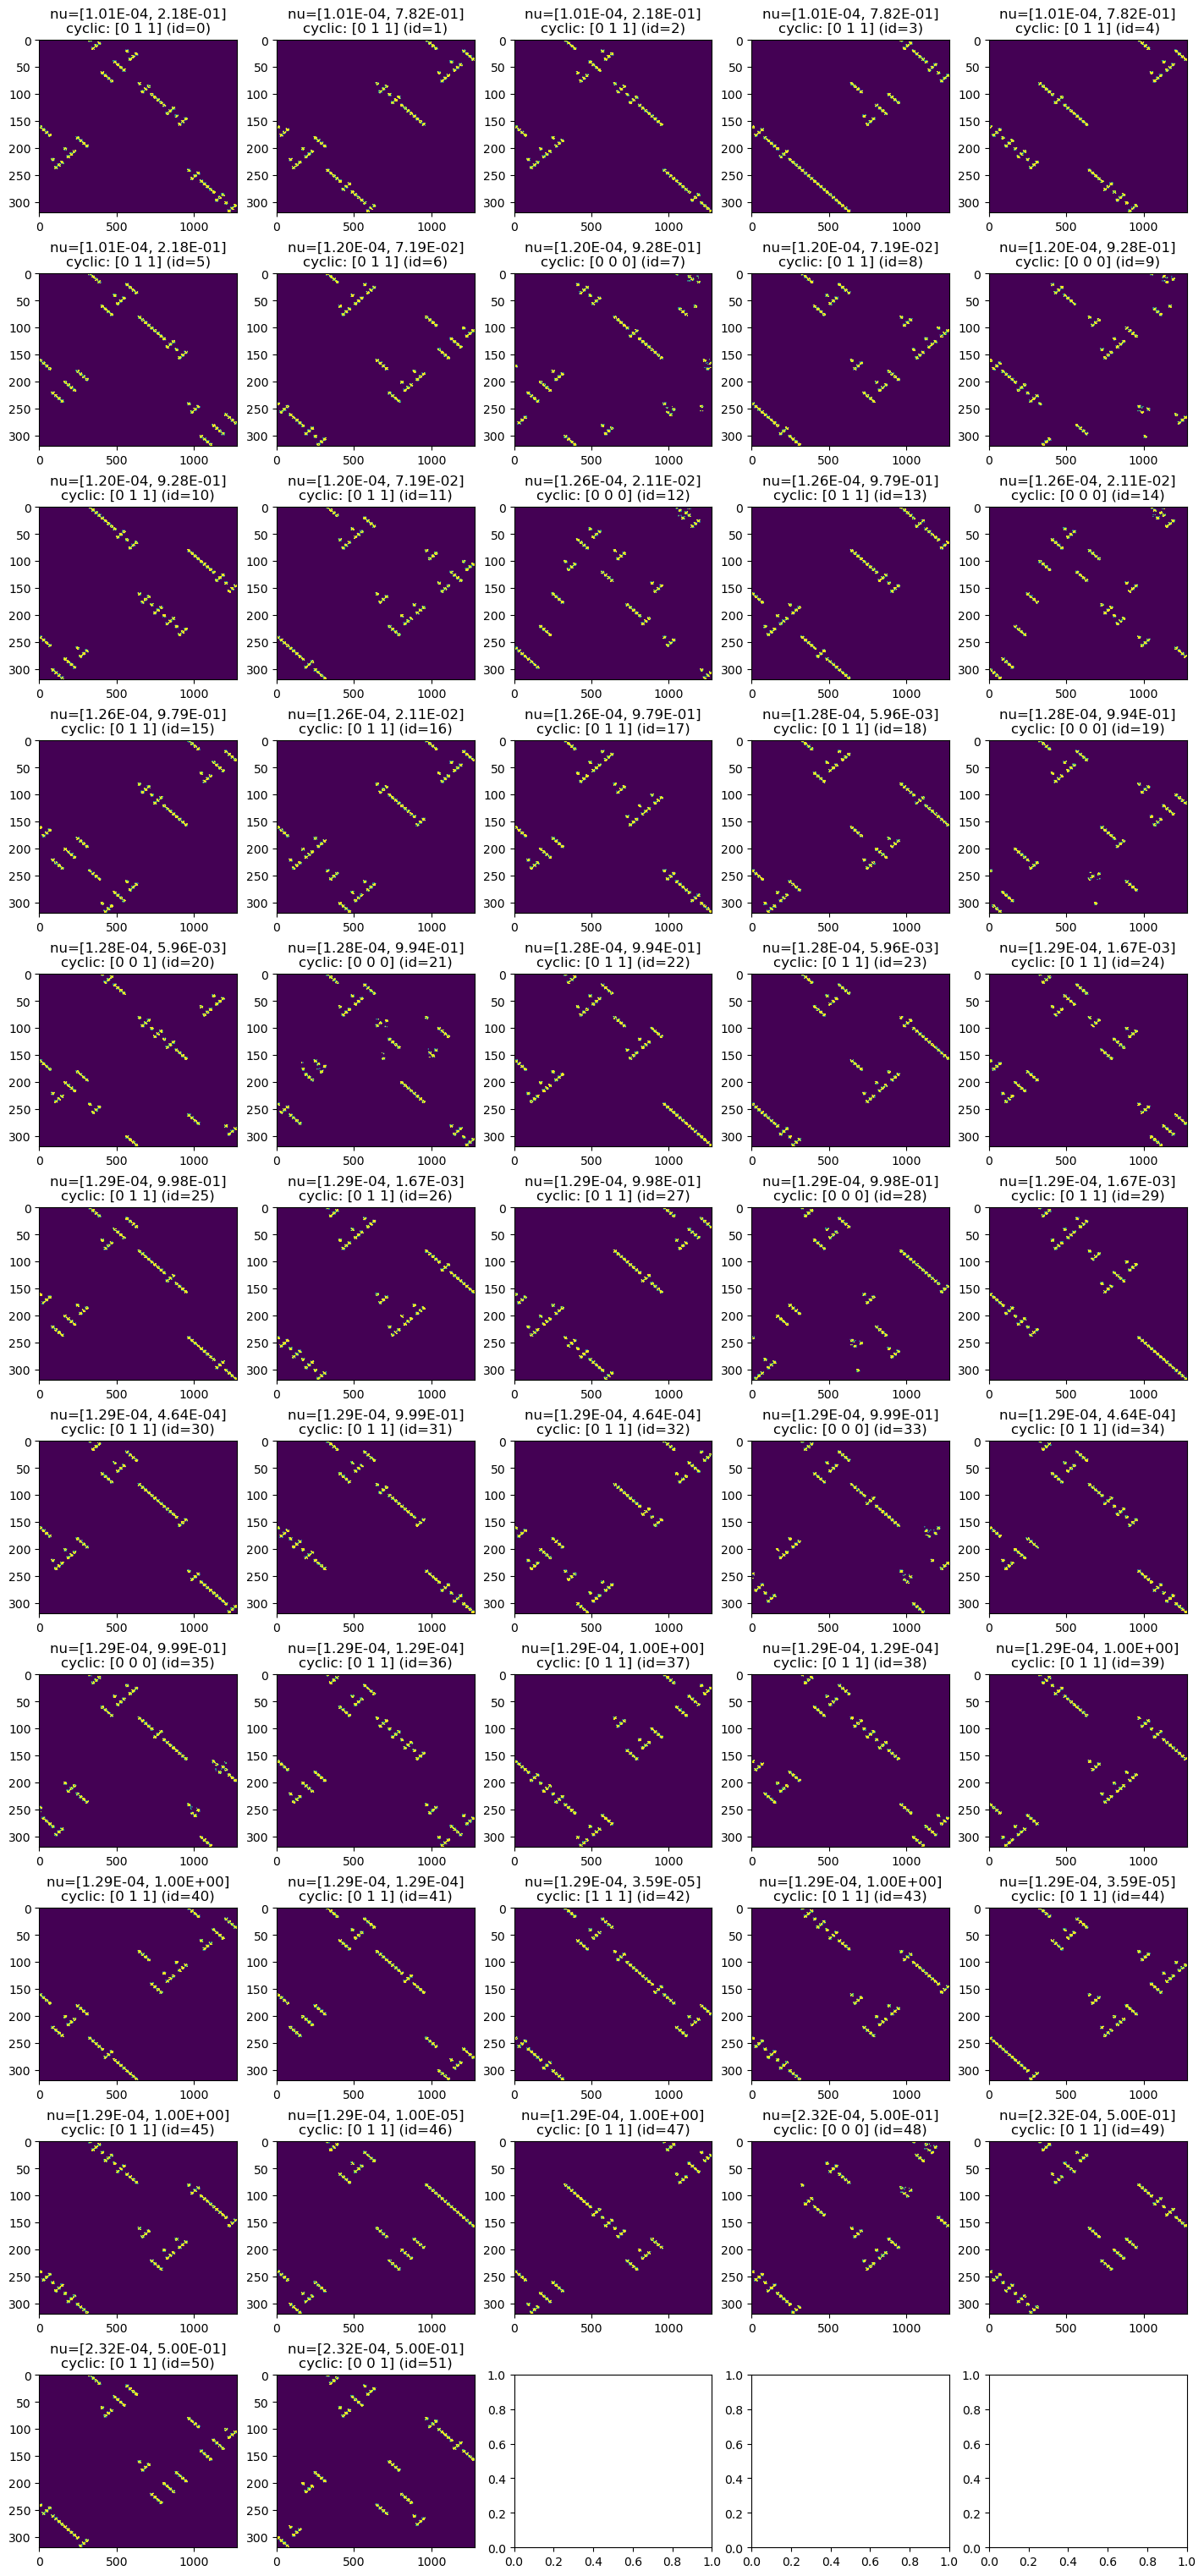

In [34]:
cols = np.min([nNus_v3, 5])
ps = [int(np.ceil(nNus_v3 / cols)), cols]
fig, axes = plt.subplots(ps[0], ps[1], figsize=(3.5 * ps[1], 3.5 * ps[0]))
plt.subplots_adjust(hspace=0.35)

# Plot all couplings with the same colorbar
for idv in range(nNus_v3):
    T = Ts_nu_v3[idv]
    T = T - T * (T < 1e-15)  # Remove noise
    cyclic = cyclic_by_levels(Trees_nu_v3[idv])

    if ps[0] > 1:
        [r, c] = np.unravel_index(idv, ps)
        sp_idx = [r, c]
    else:
        sp_idx = [idt]

    # Plot
    im = axes[*sp_idx].imshow(
        T,
        vmin=0,
        vmax=0.0001,
        # Plots matrices as squares
        aspect="auto",
        # Pixels are enlarged to improve visibility
        interpolation="auto",
        interpolation_stage="data",
    )

    axes[*sp_idx].set_title(
        "nu=[%0.2E, %0.2E]\ncyclic: %s (id=%i)" % (*nus_v3[idv, :-1], str(cyclic), idv)
    )

    print(
        "{:3d}/{} Cyclic: {} (num={})".format(idv, nNus_v3, str(cyclic), np.sum(cyclic))
    )
    if all(cyclic):
        print(f" -- All cyclic! --")

### Format graphs for paper

In [35]:
# Compile examples of nus to put on the paper
nus_paper = []

# First version of the experiment
# nus_pre = sampling_simplex_log(6, 3, n_samples=10)

# Cyclic on smallest scale
nus_pre = sampling_simplex_log(5, 3)
nus_paper.append(nus_pre[58, :])

# Cyclic on intermediate scale
nus_paper.append(nus_v3[8, :])

# Winning coupling
nus_paper.append(nus_v3[42, :])

nus_paper = np.array(nus_paper)
nNus_paper = nus_paper.shape[0]
print(nus_paper)

[[9.98901209e-01 9.98901209e-05 9.98901209e-04]
 [1.19859222e-04 7.18537157e-02 9.28026425e-01]
 [1.29133647e-04 3.59322045e-05 9.99834934e-01]]


In [36]:
# dMS -- vary nu
Ts_paper = np.zeros(nNus_paper, dtype=object)
Trees_paper = []

for idv in range(nNus_paper):
    print("nu %i/%i" % (idv + 1, nNus_paper))
    with np.printoptions(precision=3, suppress=False):
        print(nus_paper[idv, :])

    # Load cost matrices and nu
    nu = nus_paper[idv, :]
    H1 = [Hs_all[0][idt] for idt in I_nu_v3]
    H2 = [Hs_all[1][idt] for idt in I_nu_v3]

    # dMS
    time_start = time()
    T, log = gromov_wasserstein_ms(
        H1,
        H2,
        nu=nu,
        log=True,
        verbose=0,
        max_iter=1e3,
        numItermaxEmd=1e5,
        tol_abs=1e-30,
        tol_rel=1e-30,
    )
    time_end = time()
    print("dMS_nu:" + display_time(time_end - time_start))

    # Remove noise from T
    T = T * (T > 1e-15)

    Ts_paper[idv] = T

    # Compute block tree
    Trees_paper.append(extract_multiscale_info(T, params3[0], params3[1]))
    print()

nu 1/3
[9.989e-01 9.989e-05 9.989e-04]
dMS_nu:0:00:02.11

nu 2/3
[1.199e-04 7.185e-02 9.280e-01]
dMS_nu:0:00:01.94

nu 3/3
[1.291e-04 3.593e-05 9.998e-01]
dMS_nu:0:00:01.81



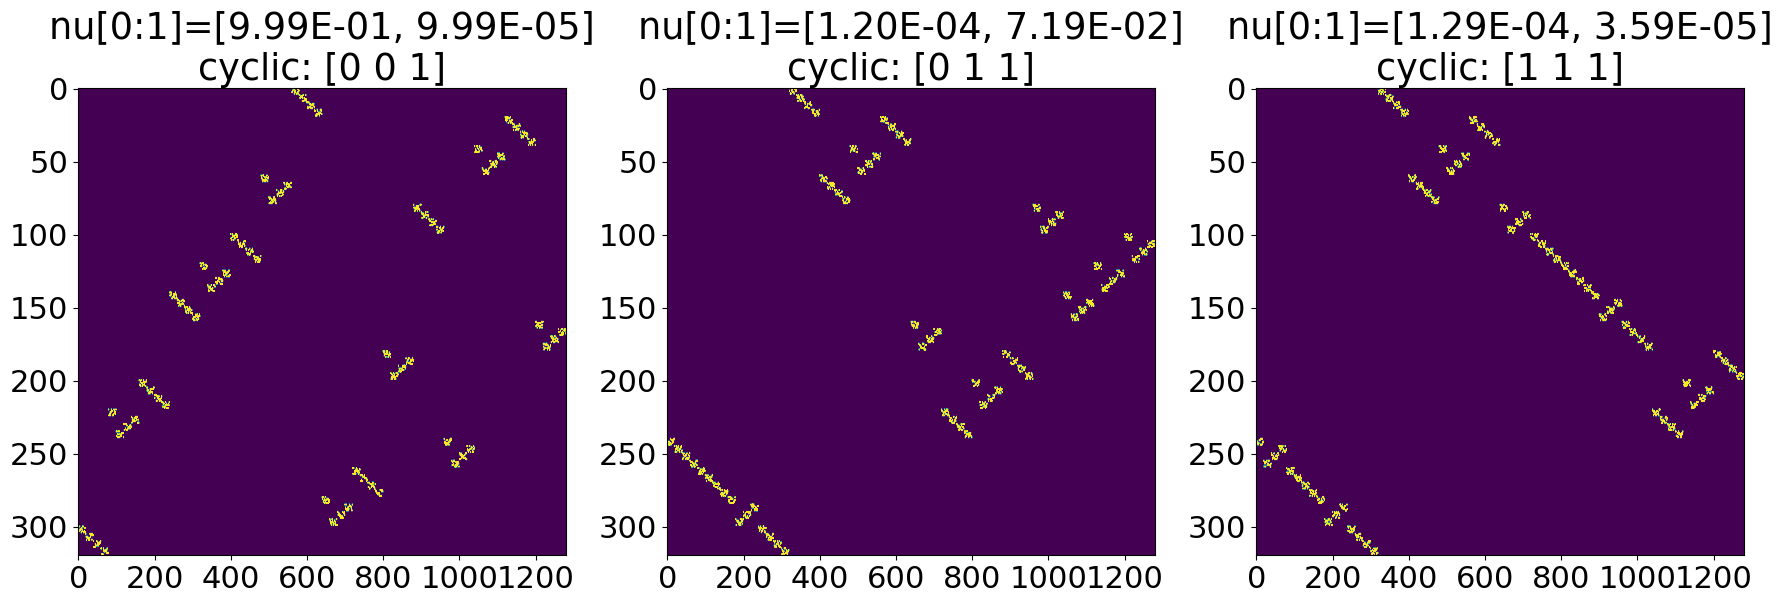

In [37]:
with rc_context({"font.size": 22}):
    scale = 6
    fig, axes = plt.subplots(
        1, nNus_paper, figsize=(scale * nNus_paper, scale + 0.5), sharey=False
    )
    for idx in range(nNus_paper):
        # Load coupling and find at which levels it's cyclic
        T = Ts_paper[idx]
        cyclic = cyclic_by_levels(Trees_paper[idx])

        # Plot
        im = axes[idx].imshow(
            T,
            vmin=0,
            vmax=0.0001,
            # Plots matrices as squares
            aspect="auto",
            # Pixels are enlarged to improve visibility
            interpolation="auto",
            interpolation_stage="data",
        )

        axes[idx].set_title(
            "nu[0:1]=[%0.2E, %0.2E]\ncyclic: %s" % (*nus_paper[idx, :-1], str(cyclic))
        )

    # Save for publication
    plt.tight_layout()
    plt.savefig(Path(folder_figs, "Nested_3_cycles_MS_3.pdf"), bbox_inches="tight")